In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import json 
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize

In [112]:
from data_utils import read_data, normalization
from opt_utils import func, f_param, get_x0

In [113]:
bounds = Bounds(
    np.array([0, 0, 0, 0, 0, 0], dtype=np.float64), 
    np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float64))

cons = [
    {
        'type': 'eq',
        'fun': lambda x: np.array([x[0] + x[1] + x[2] - 1]),
        'jac': lambda x: np.array([1.0, 1.0, 1.0, 0, 0, 0])
    },
    {
        'type': 'ineq',
        'fun': lambda x: np.array([x[3] - x[4]]),
        'jac': lambda x: np.array([0, 0, 0, 1.0, -1.0, 0])
    },
]

In [119]:
source_path = 'CFs'

/home/elavrukhin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


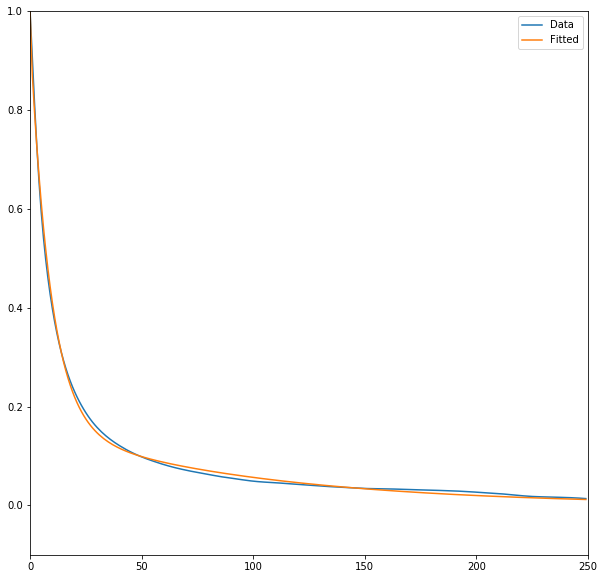

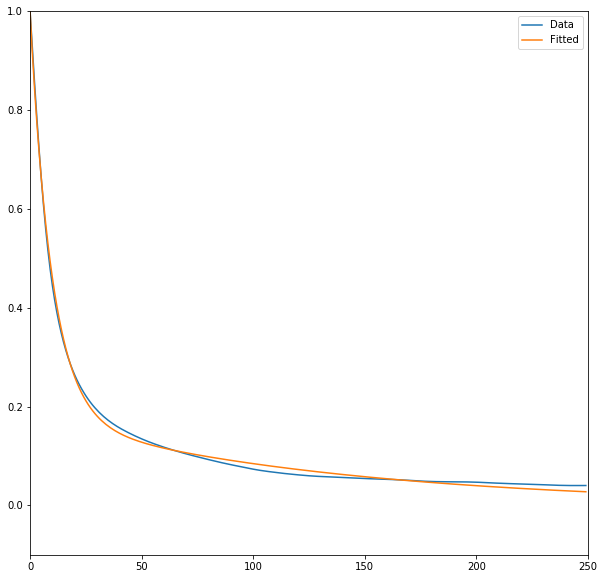

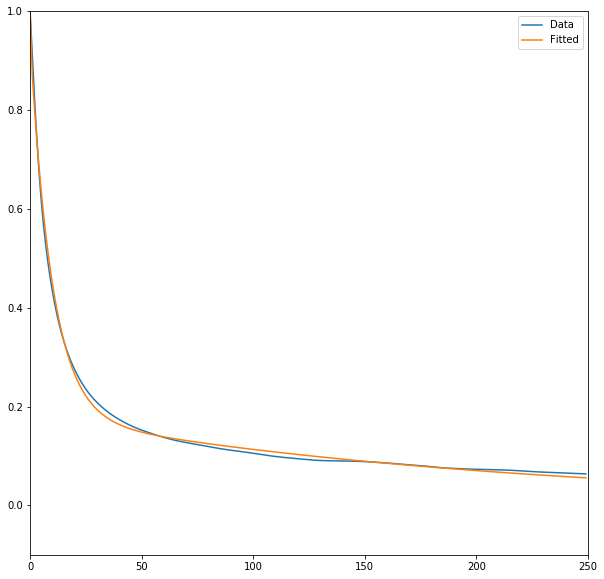

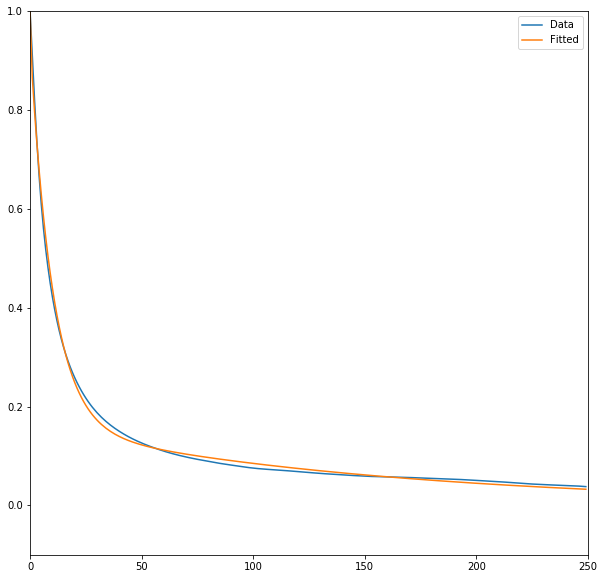

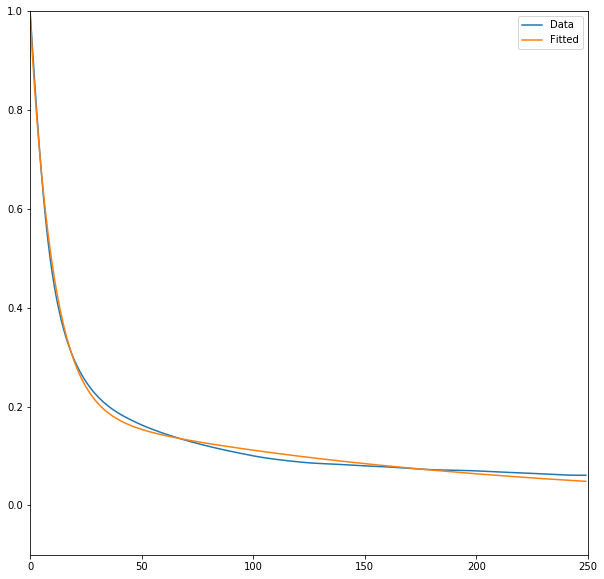

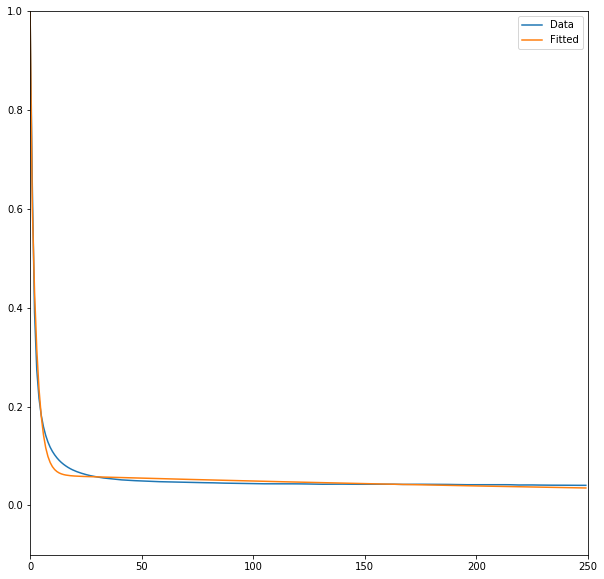

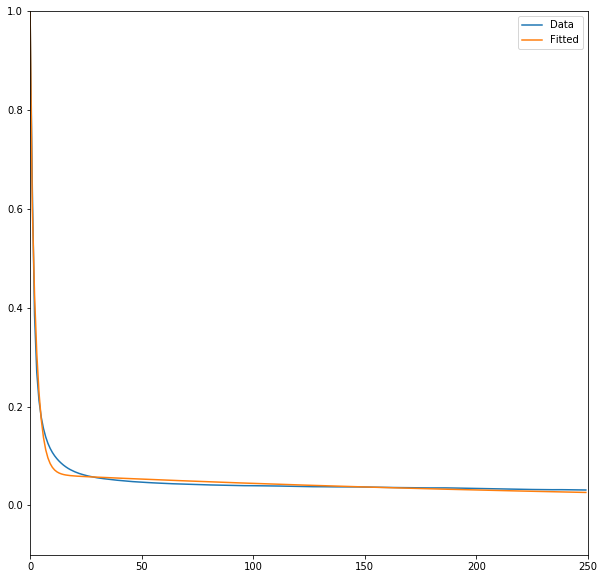

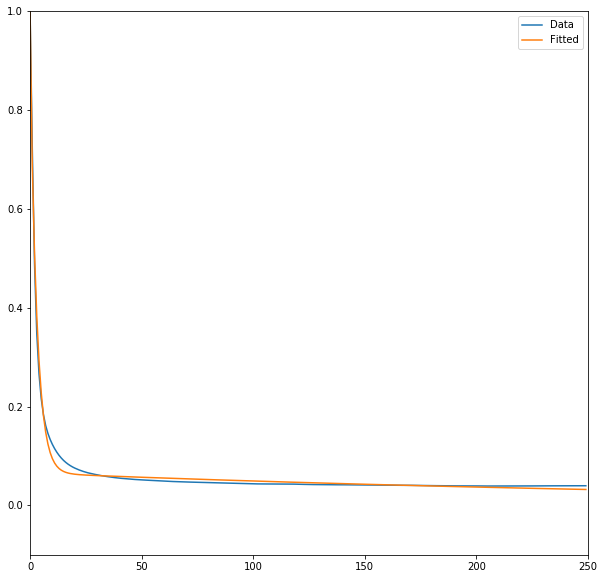

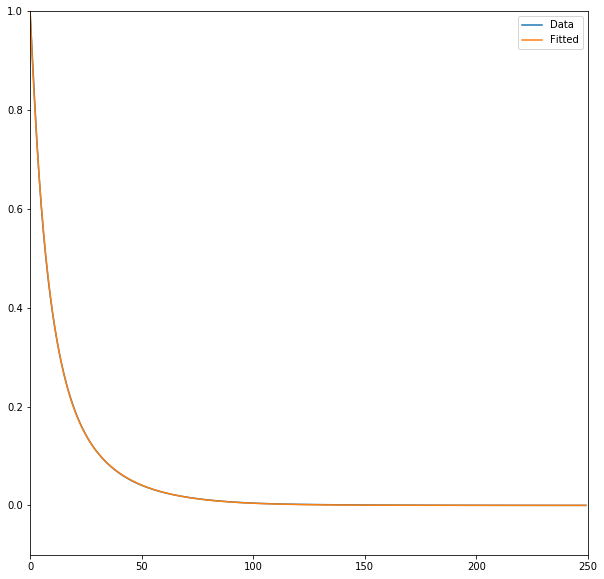

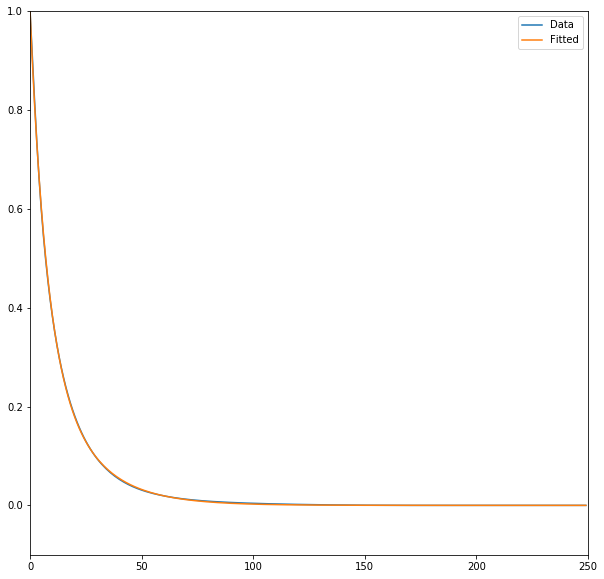

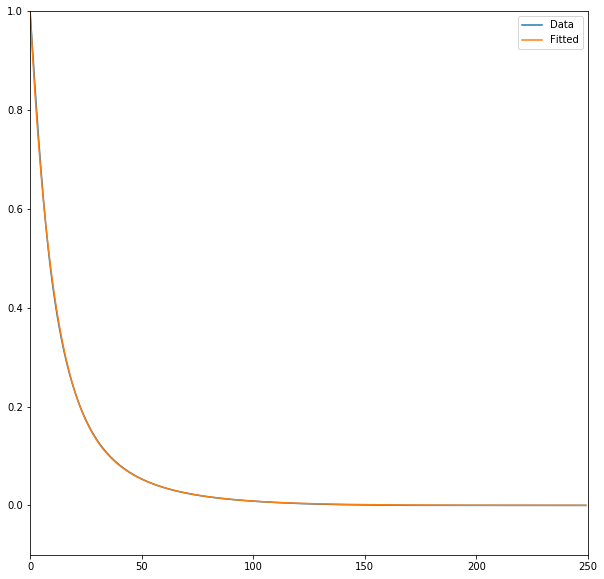

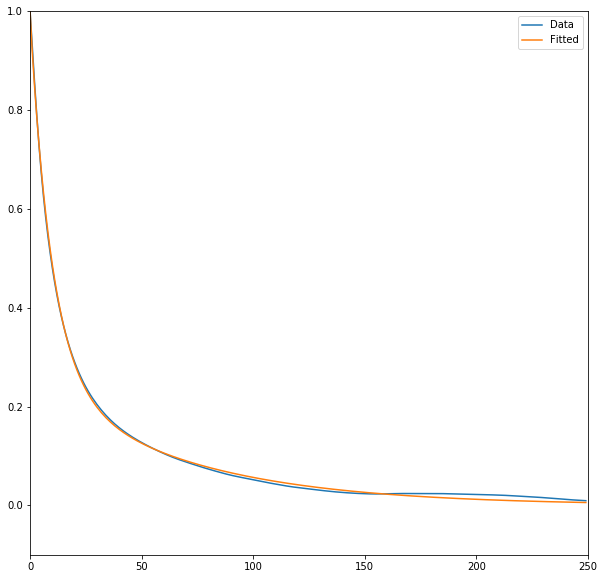

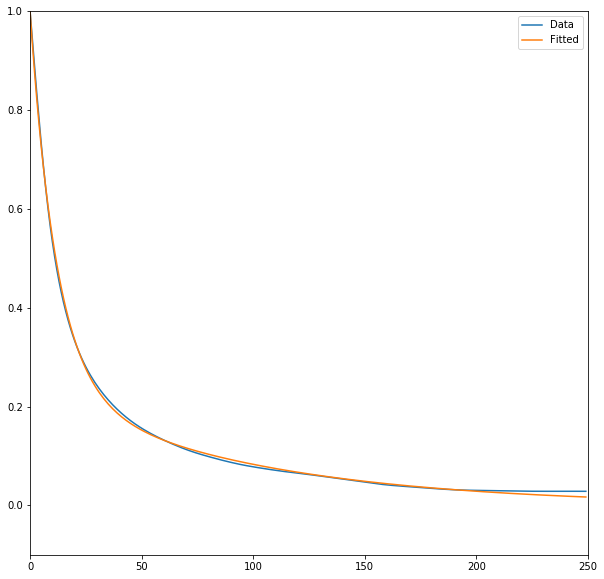

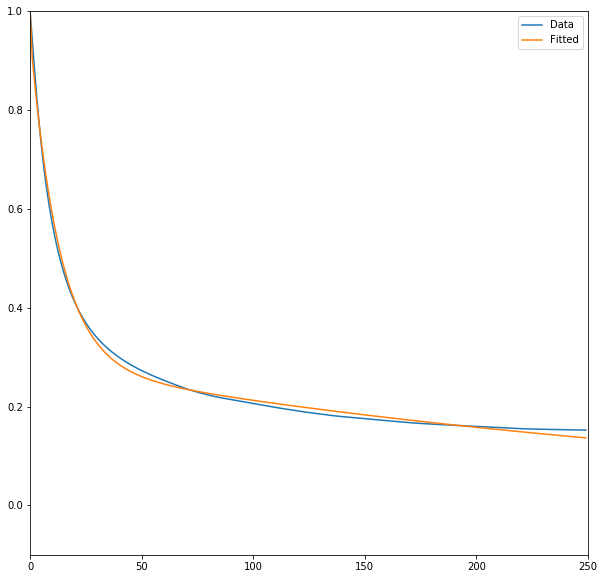

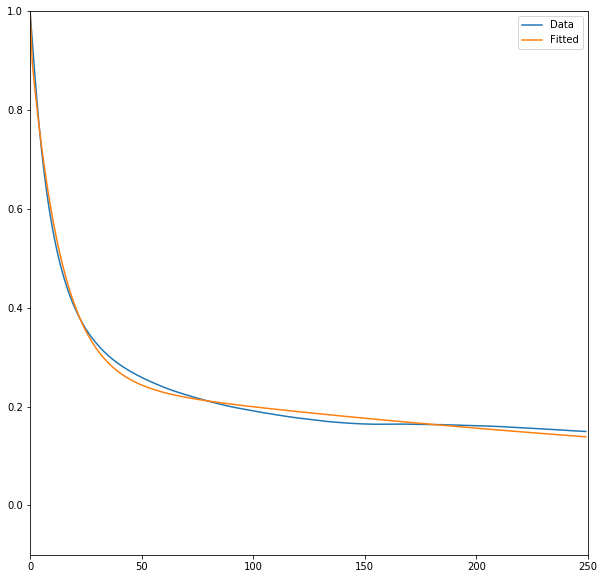

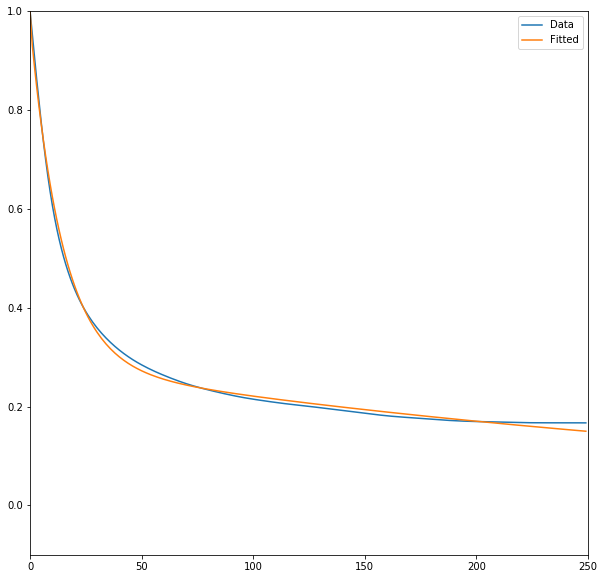

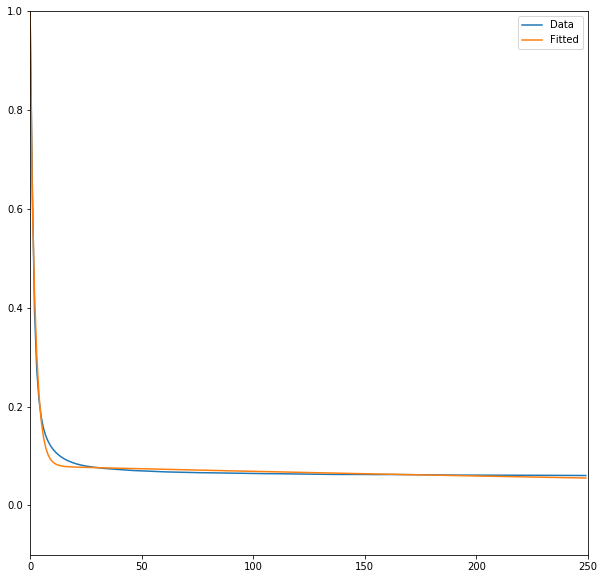

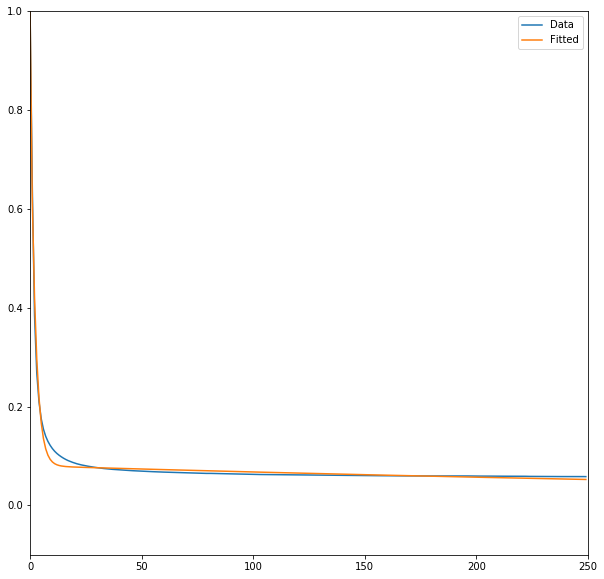

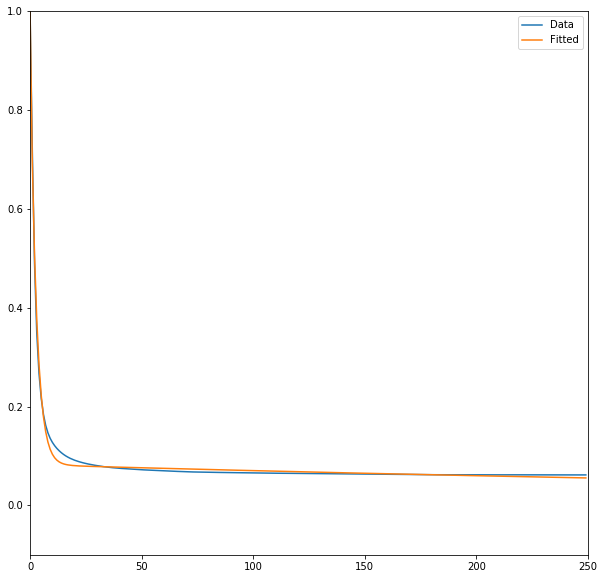

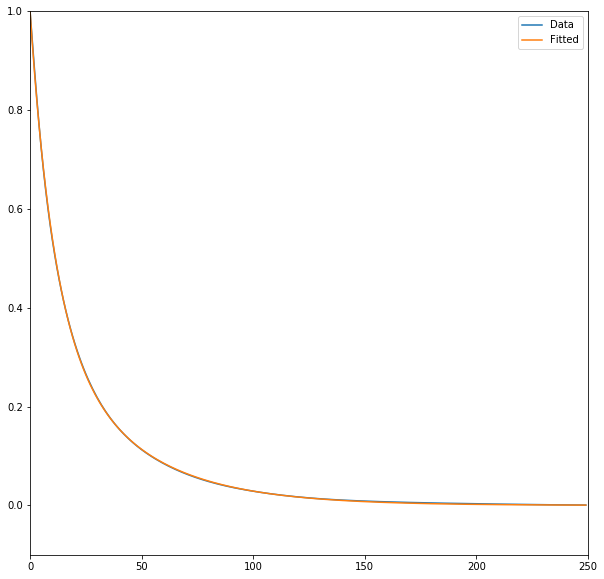

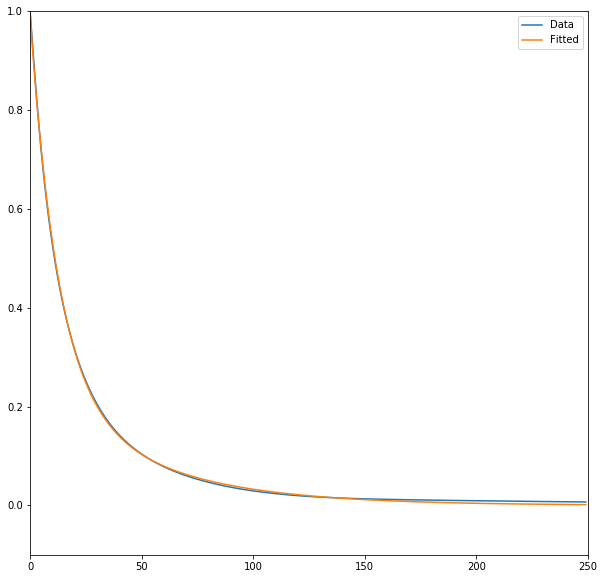

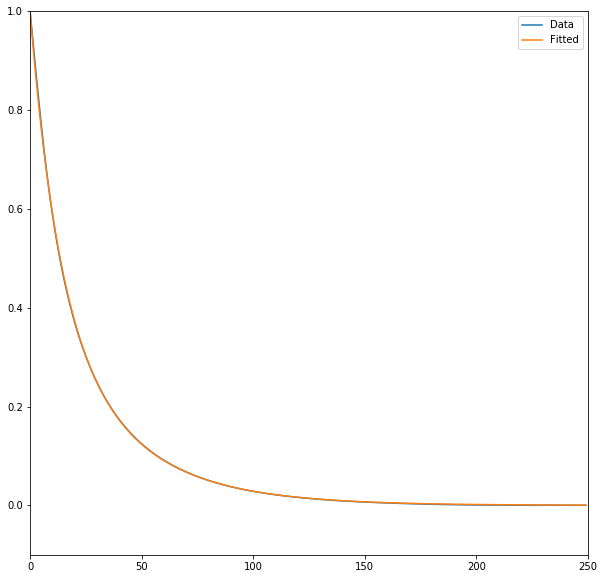

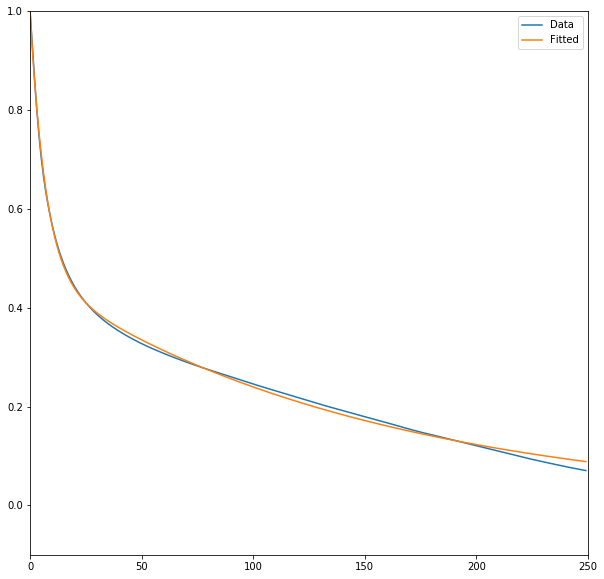

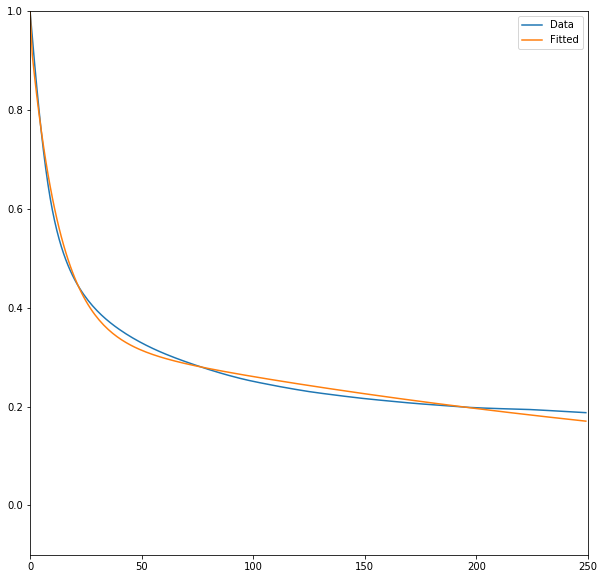

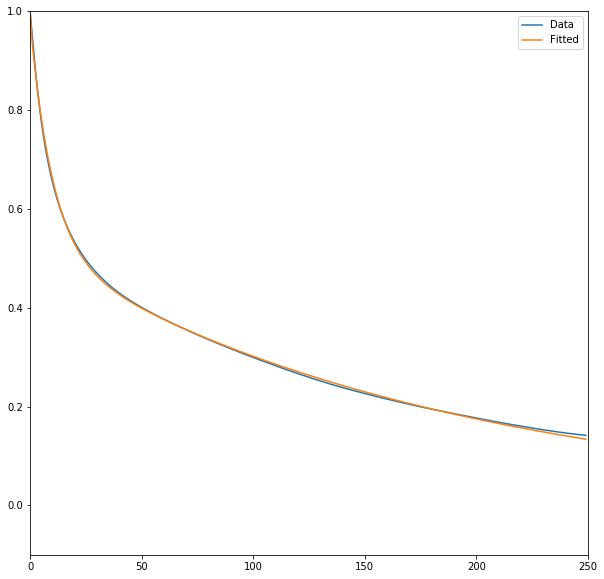

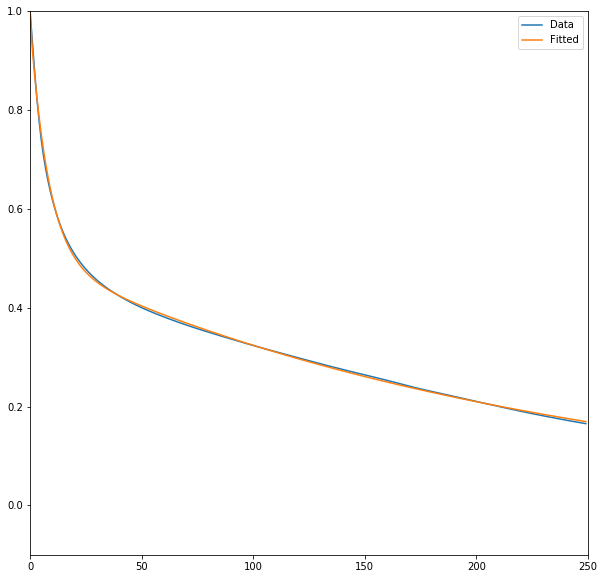

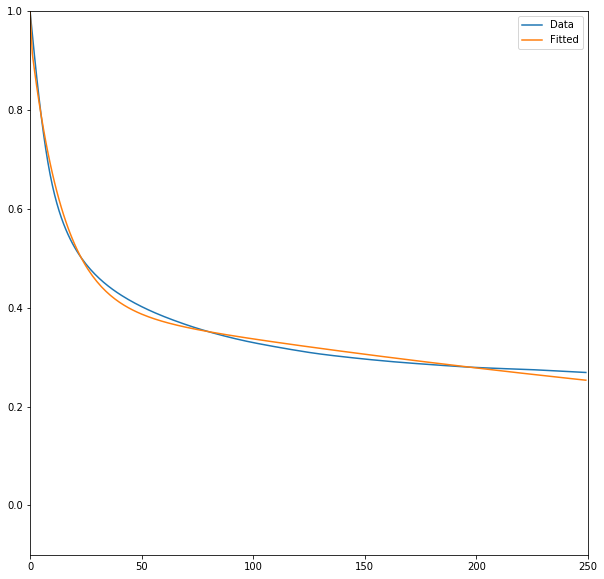

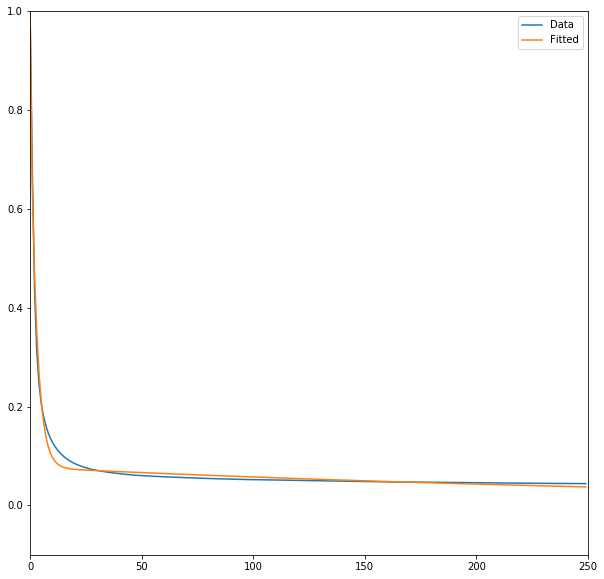

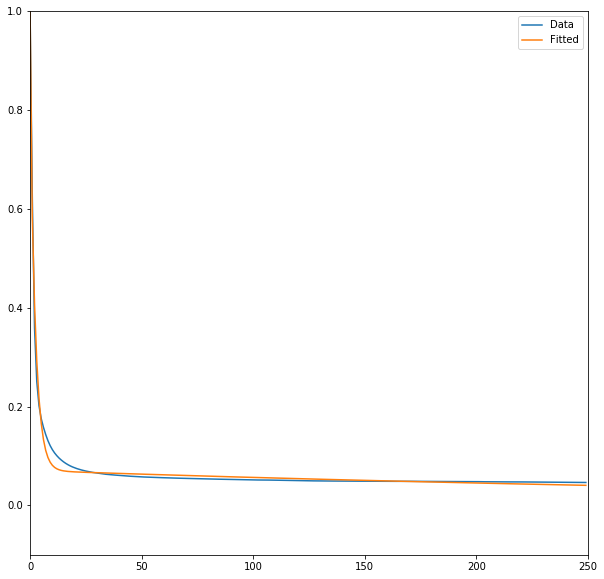

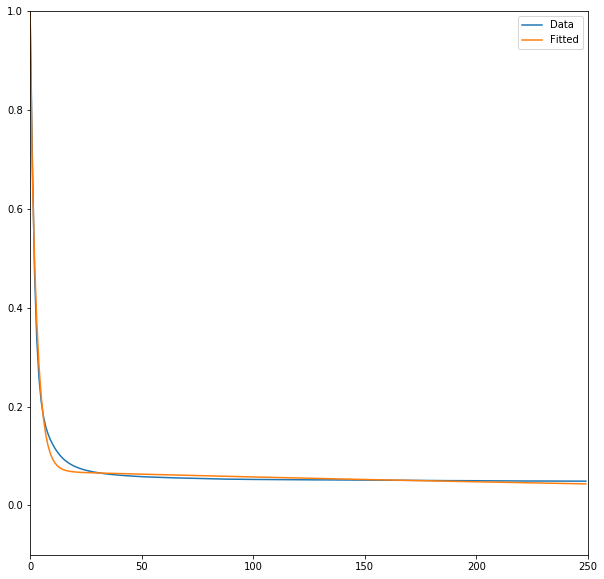

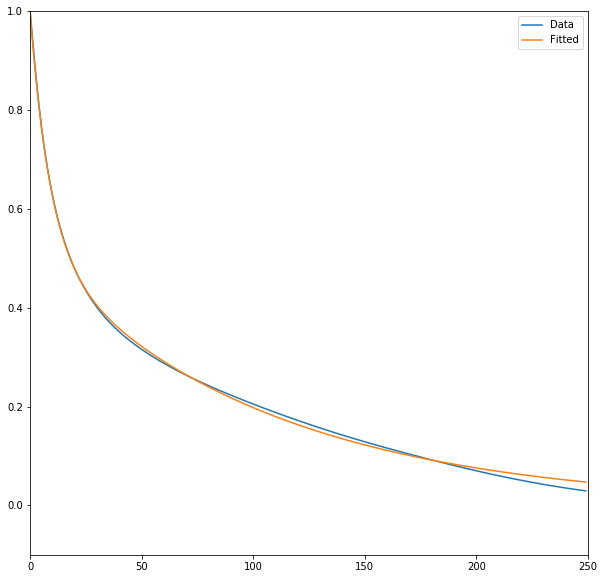

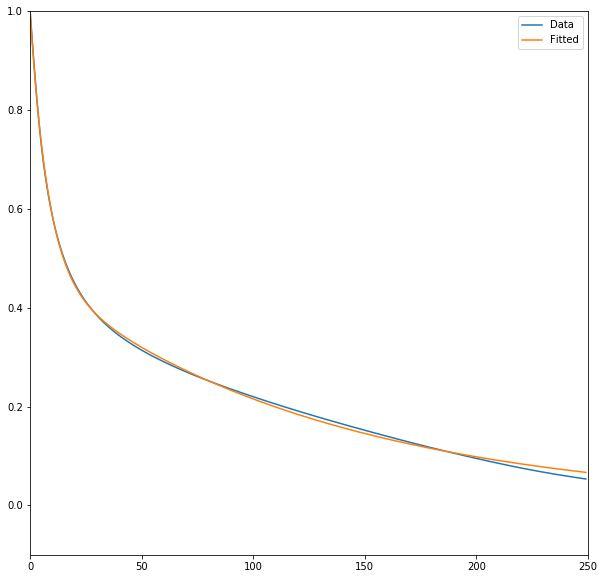

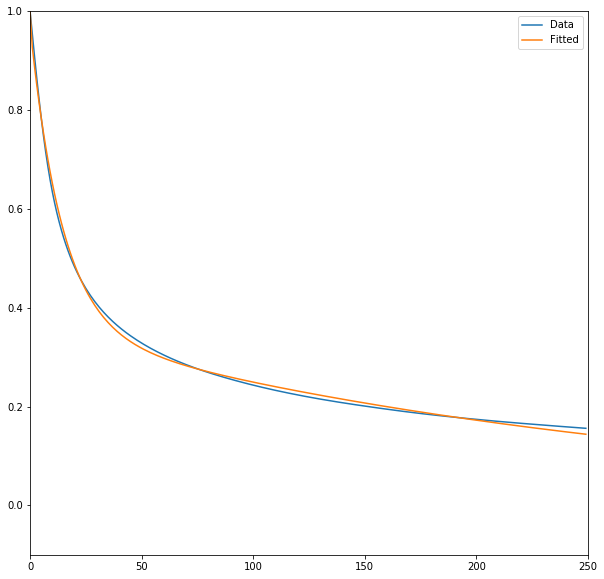

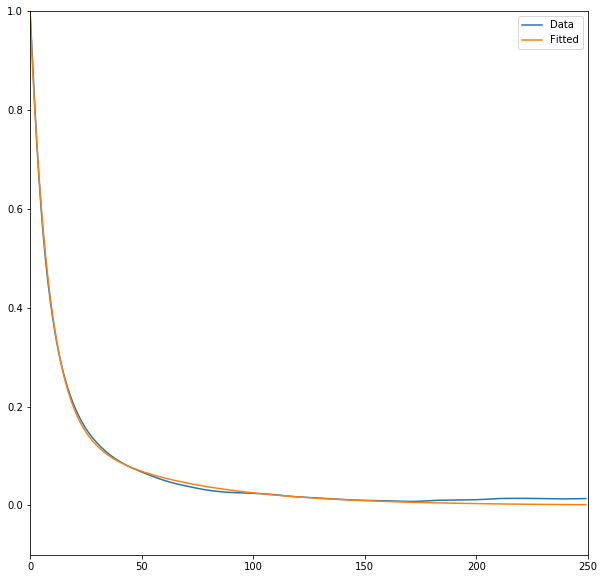

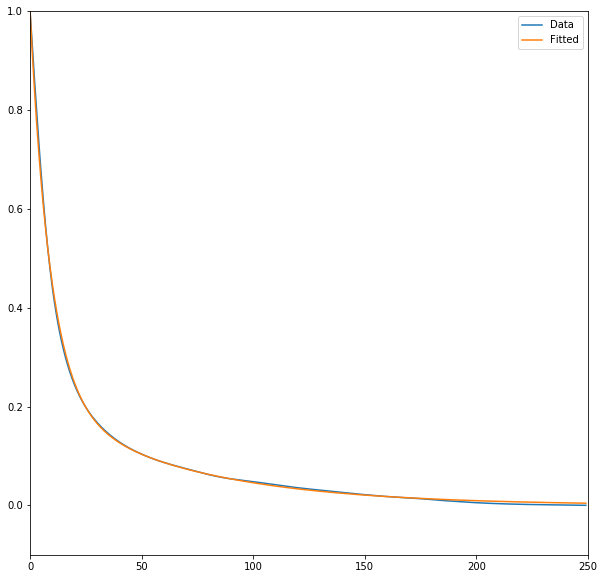

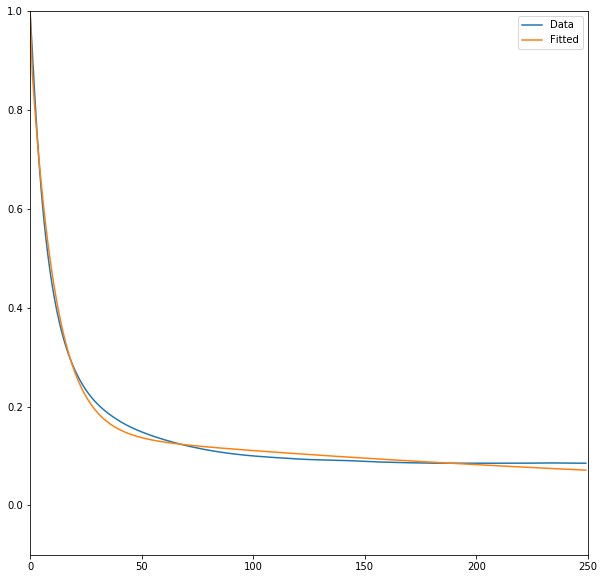

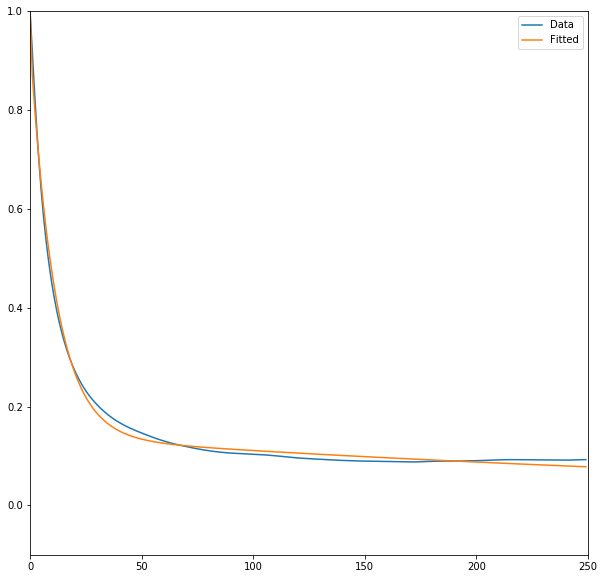

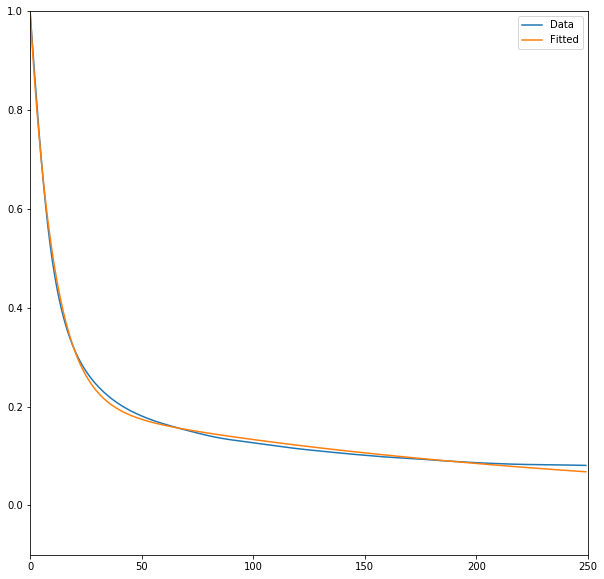

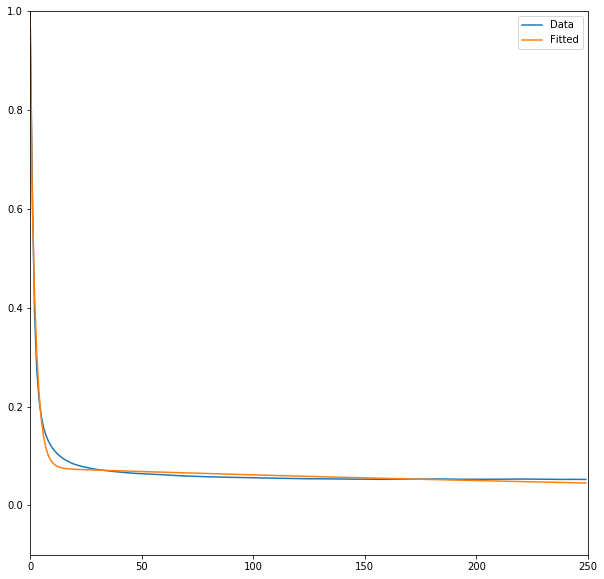

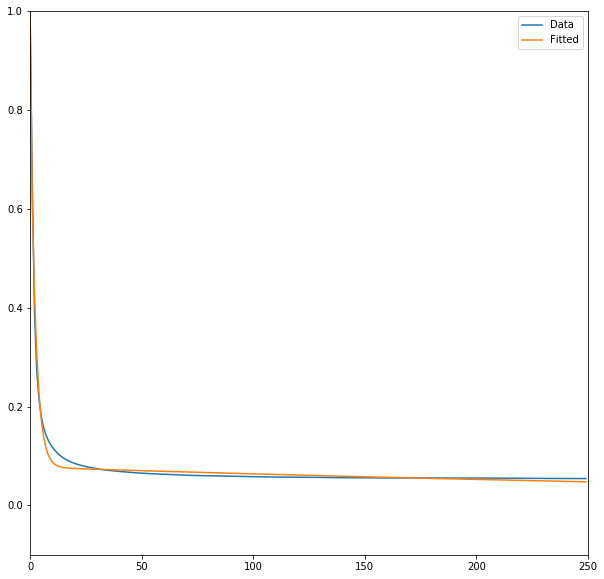

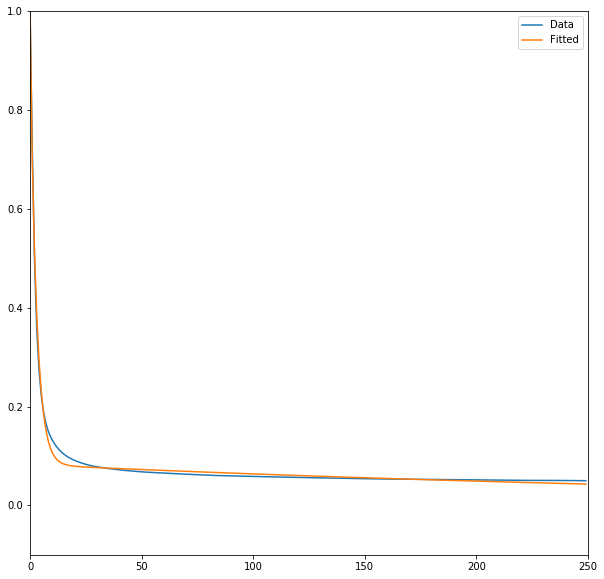

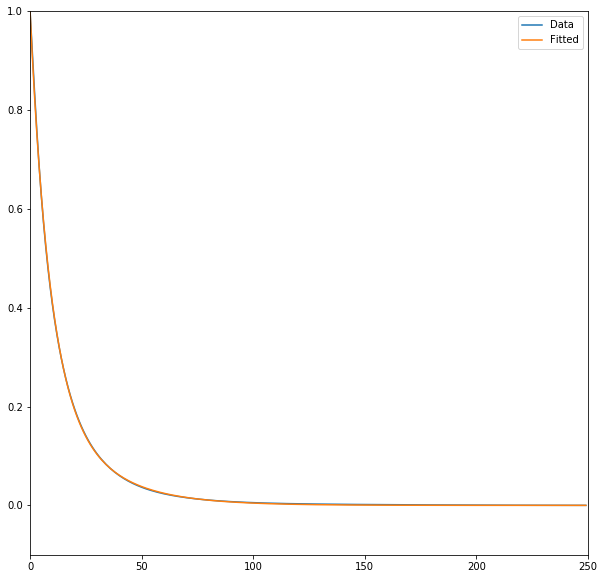

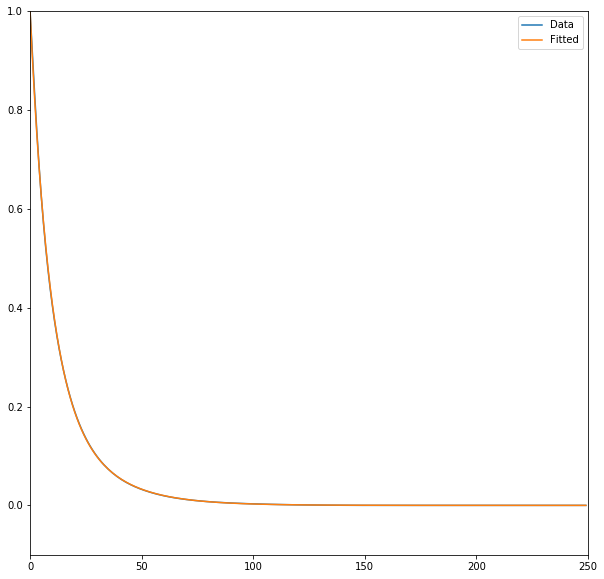

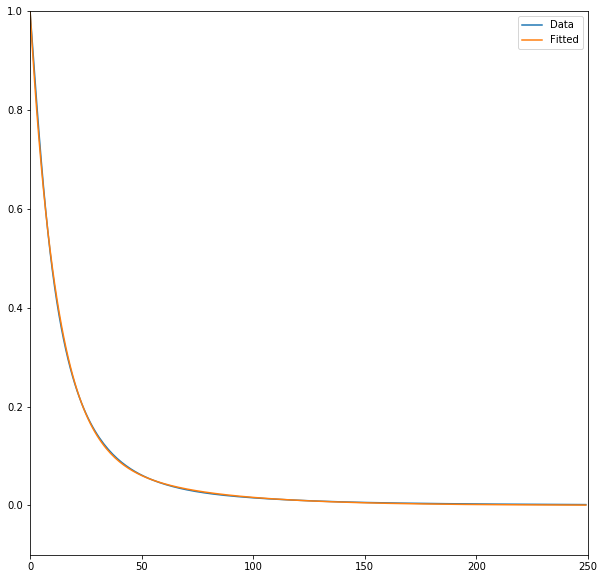

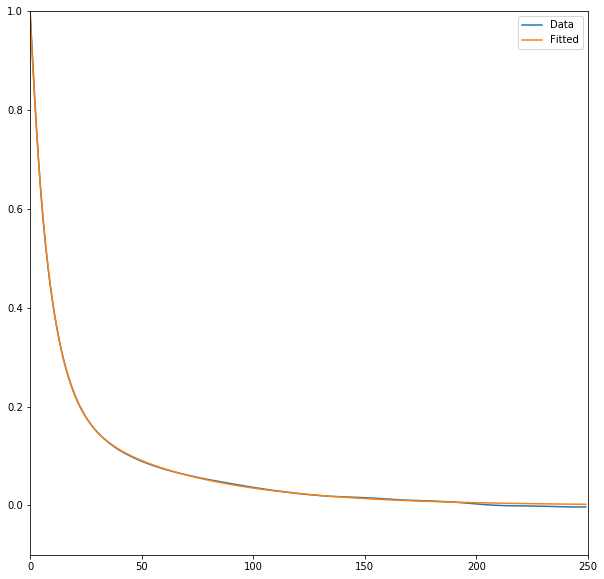

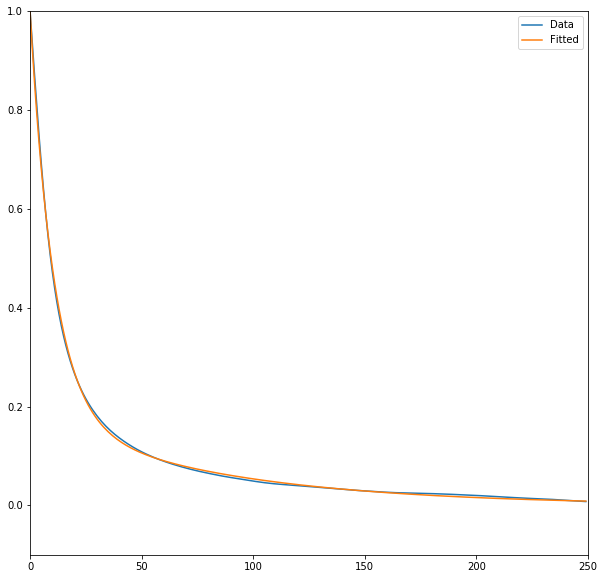

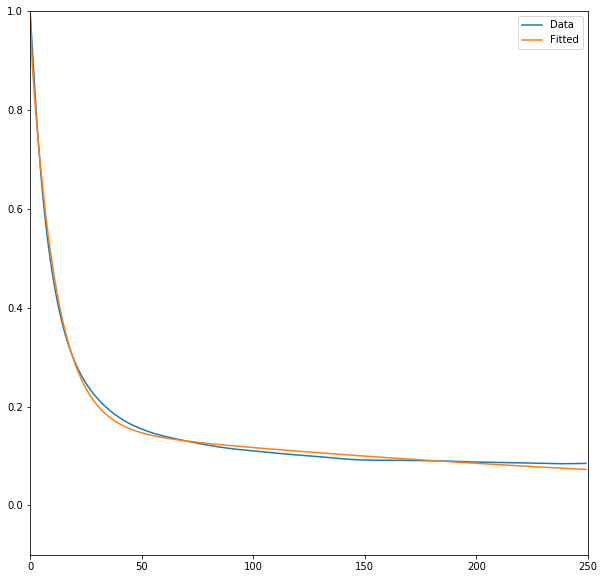

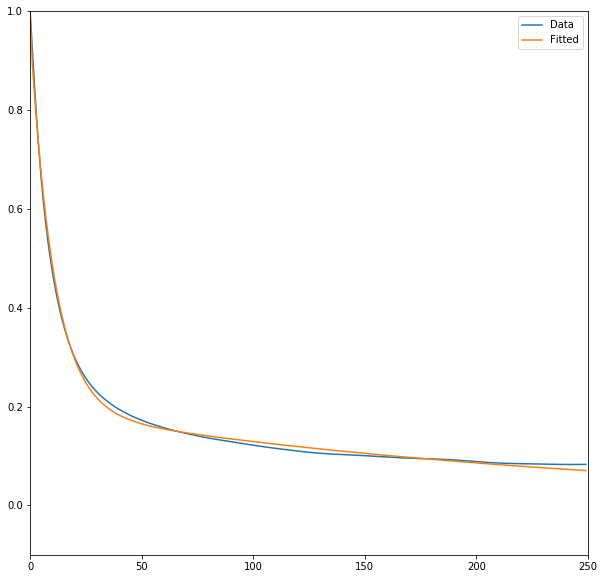

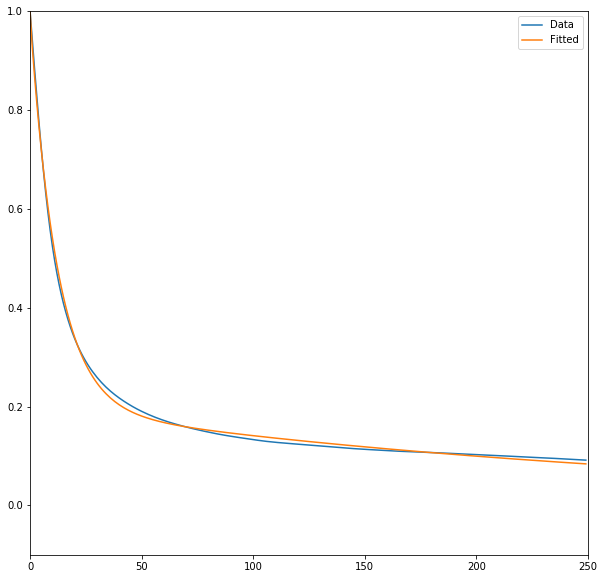

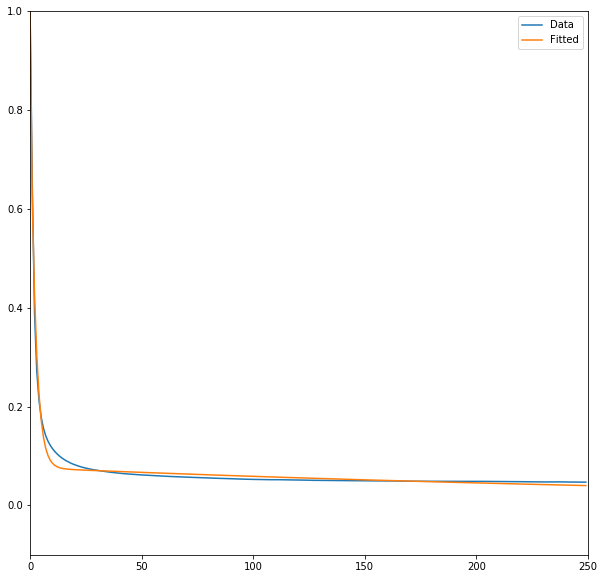

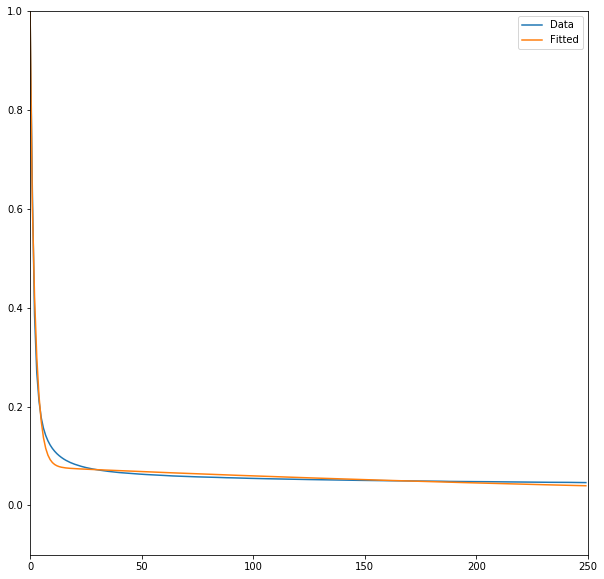

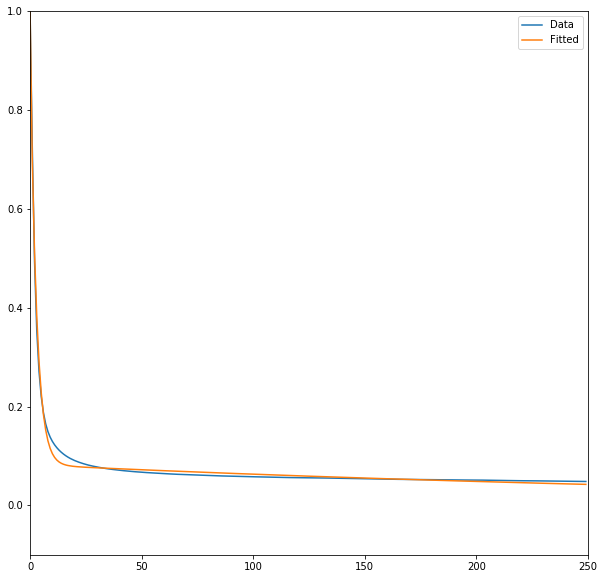

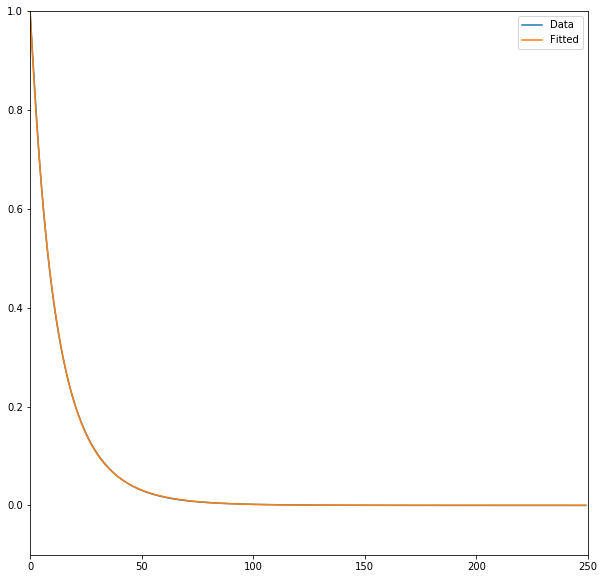

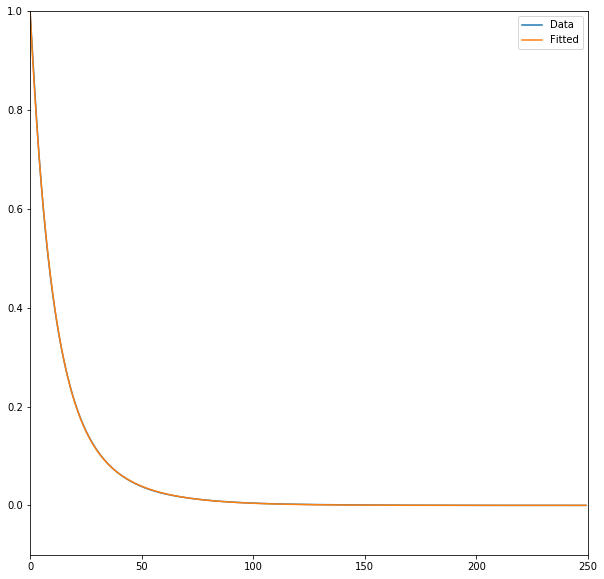

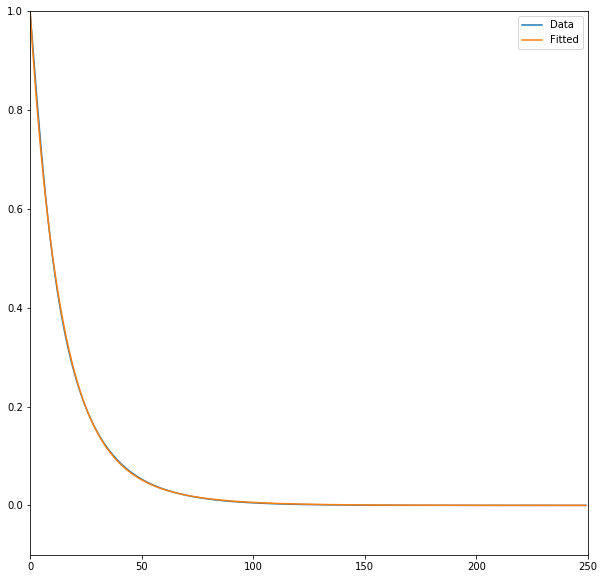

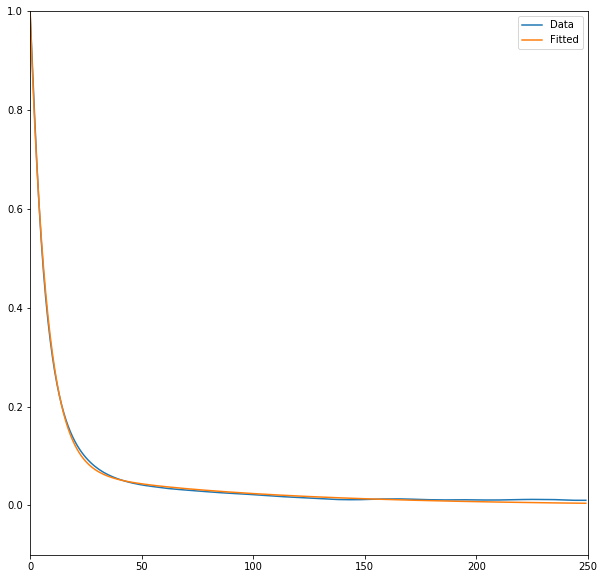

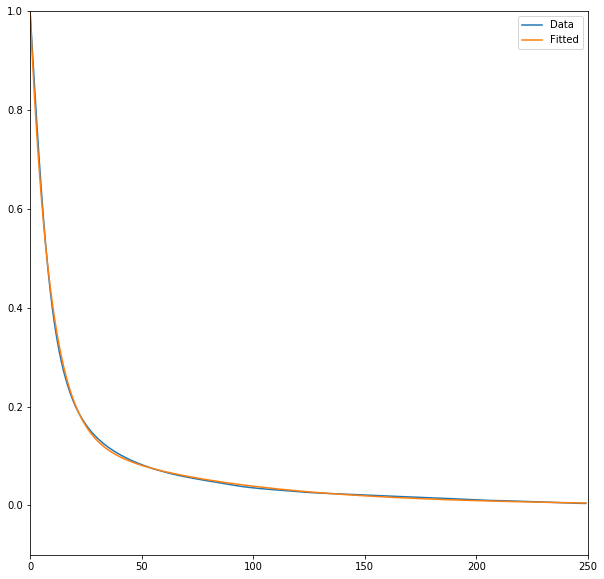

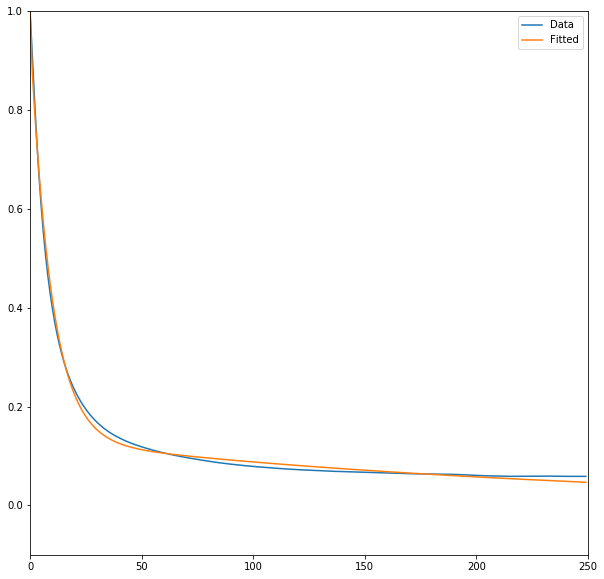

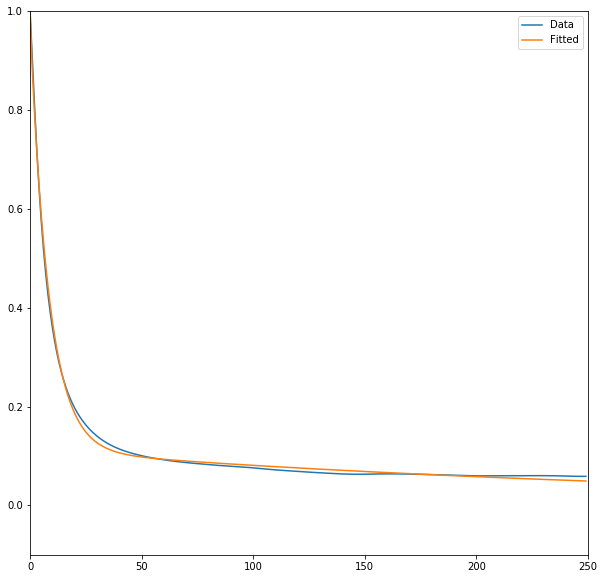

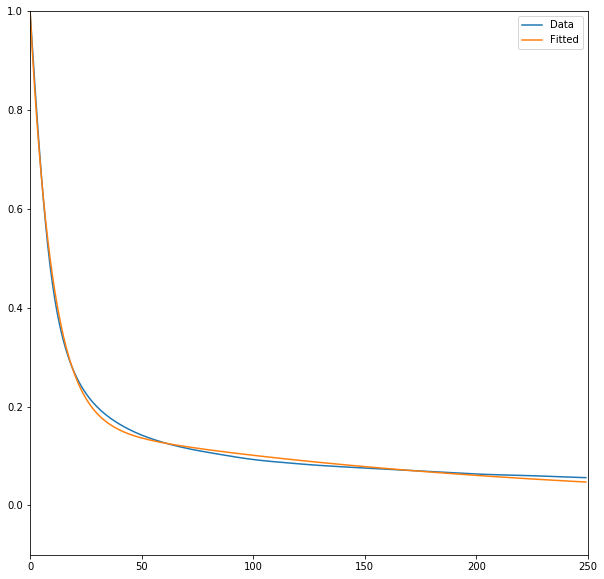

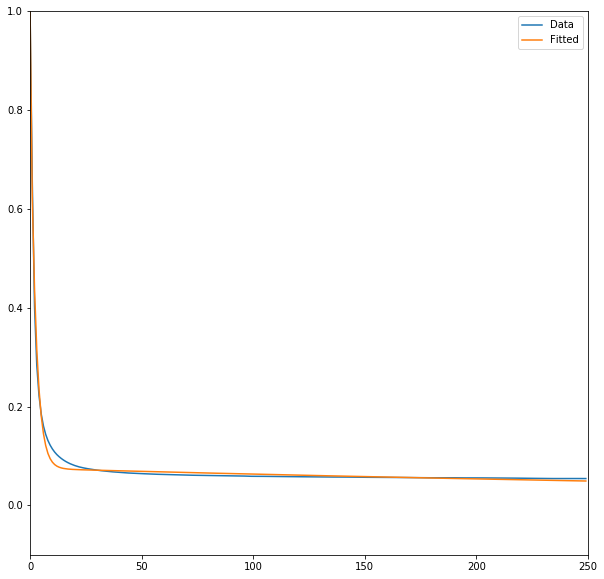

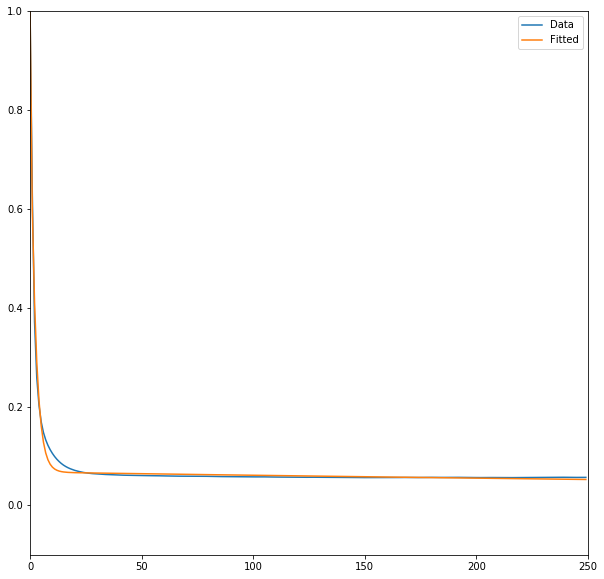

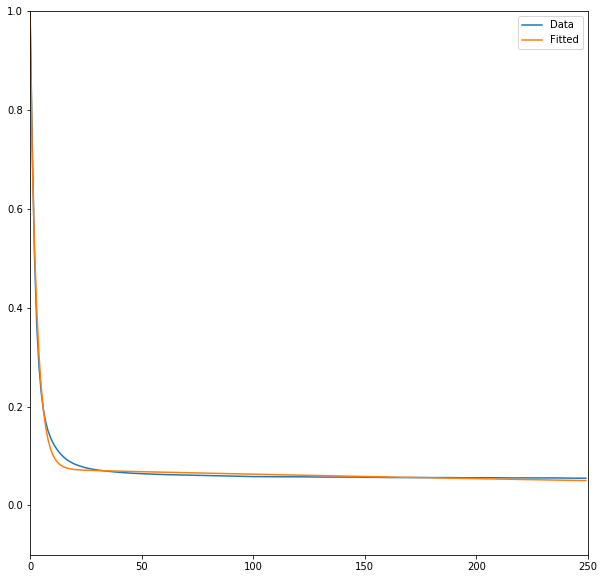

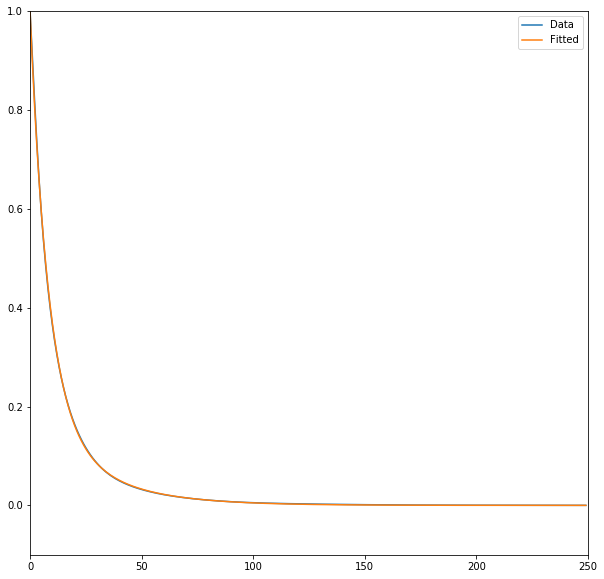

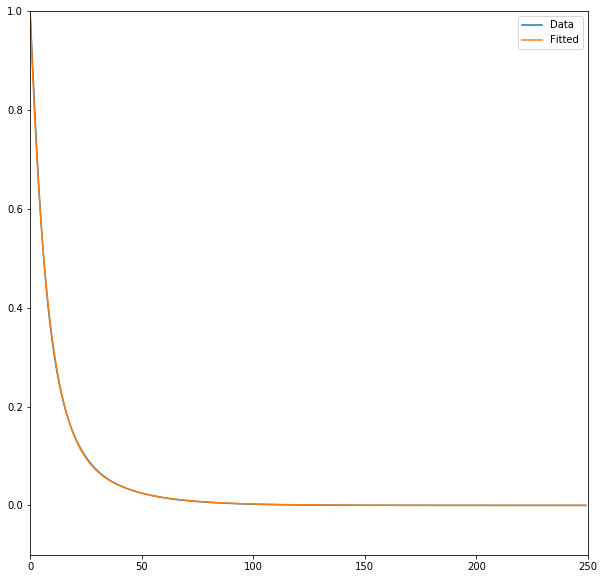

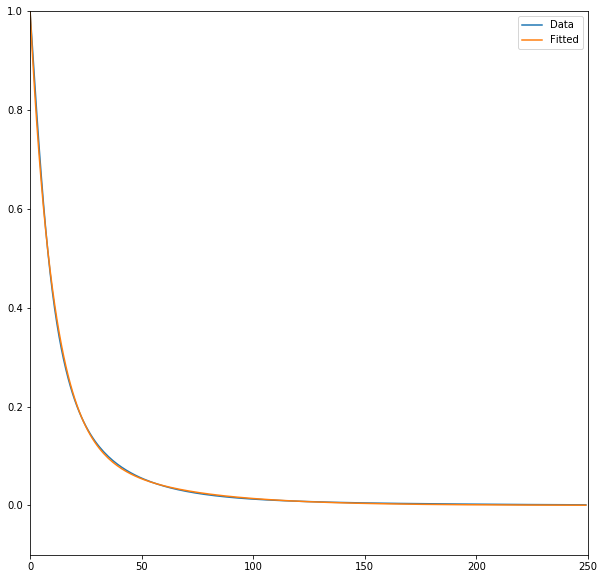

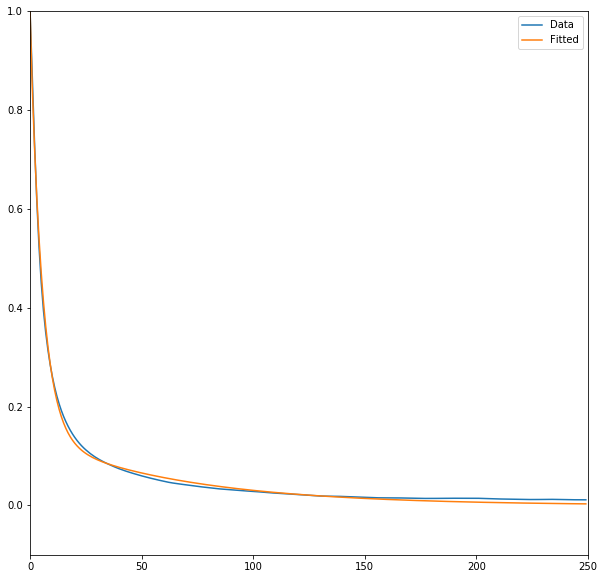

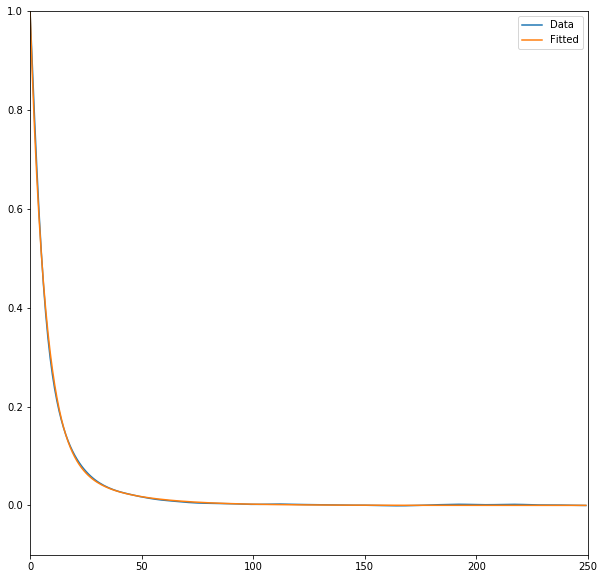

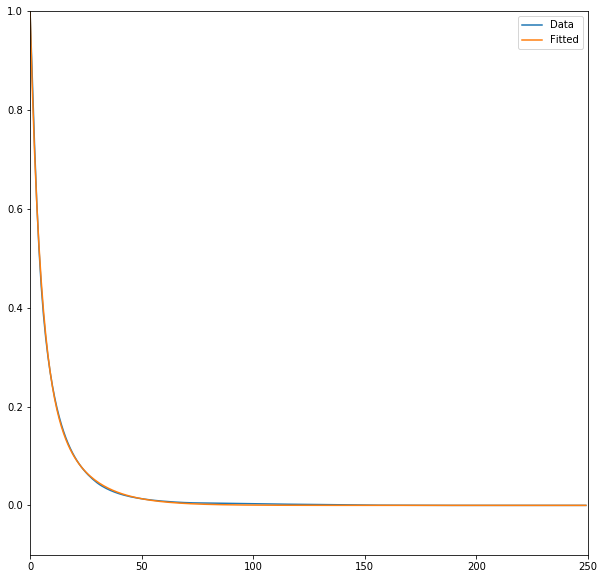

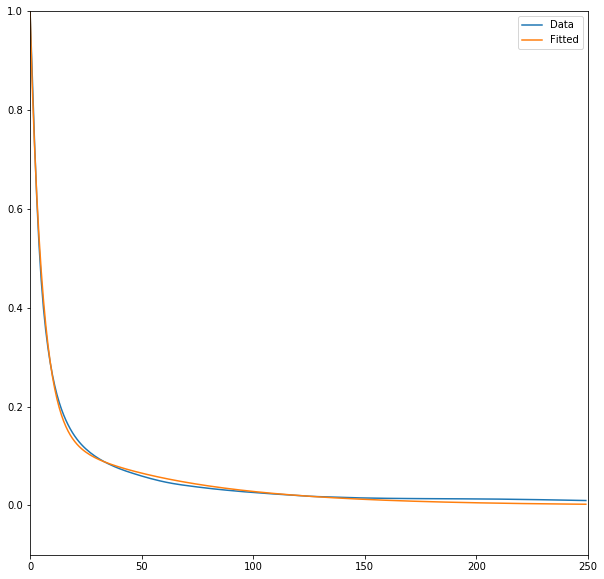

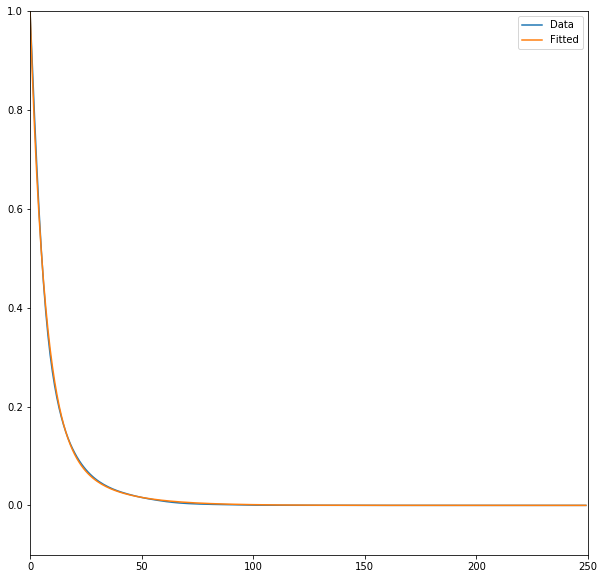

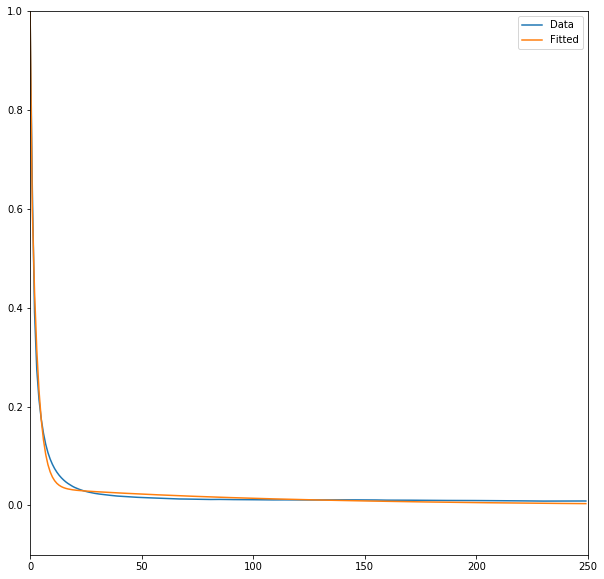

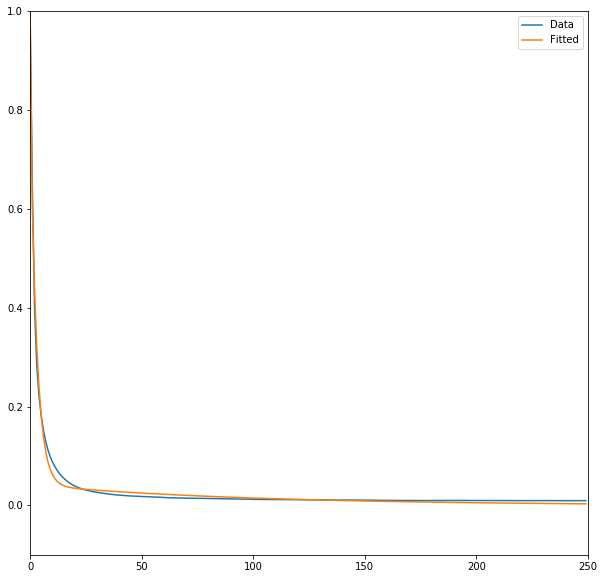

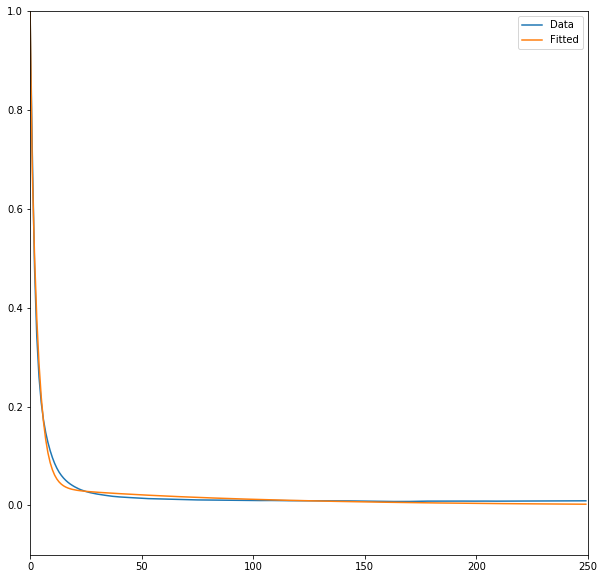

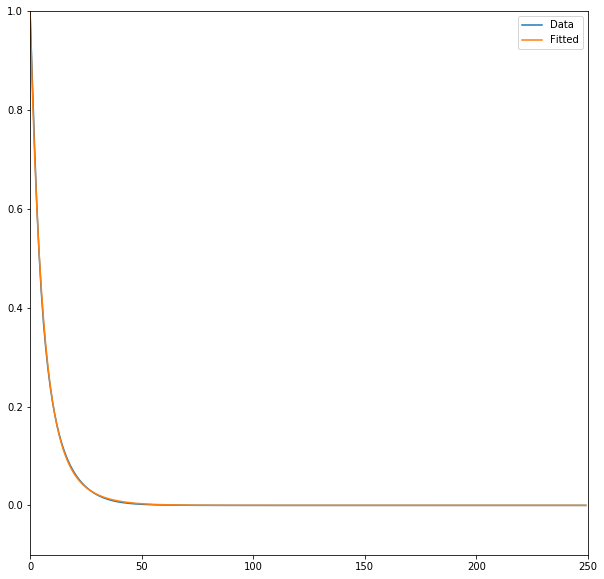

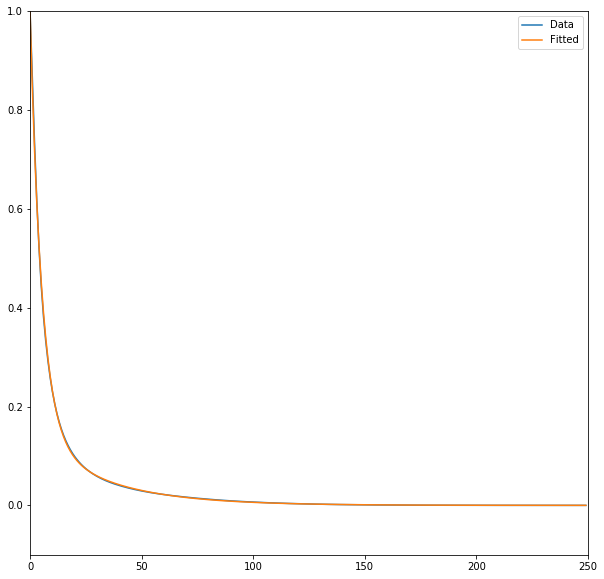

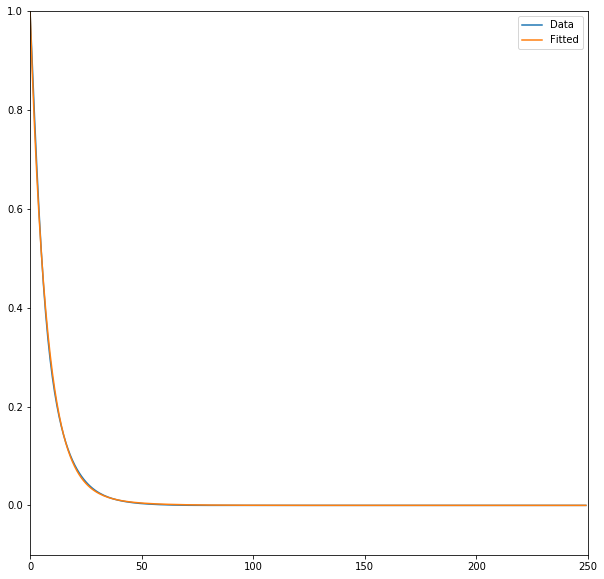

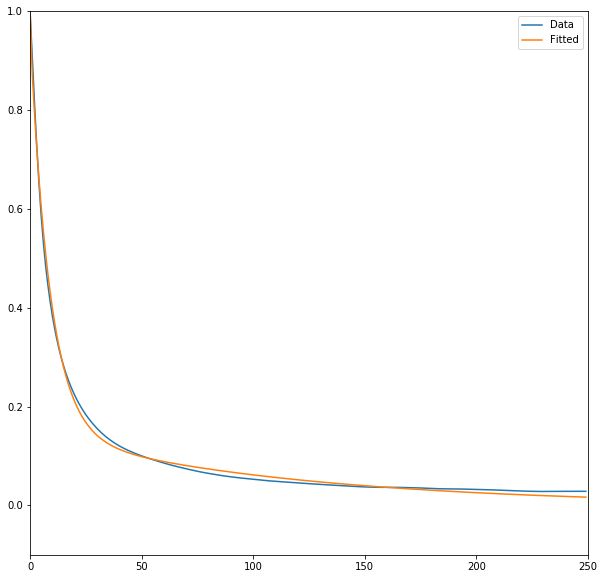

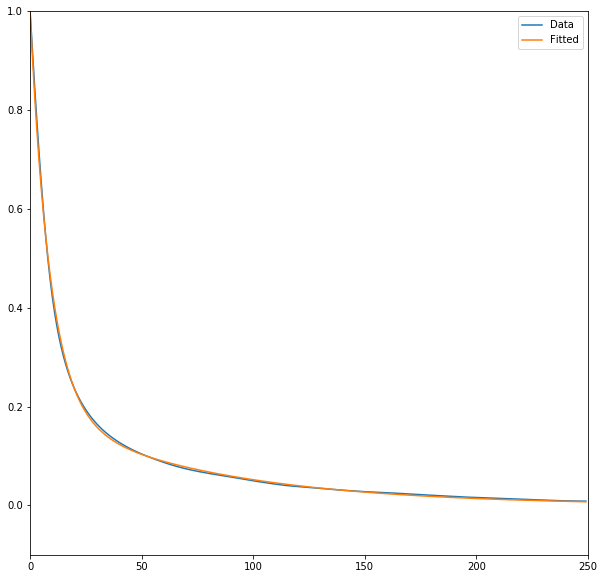

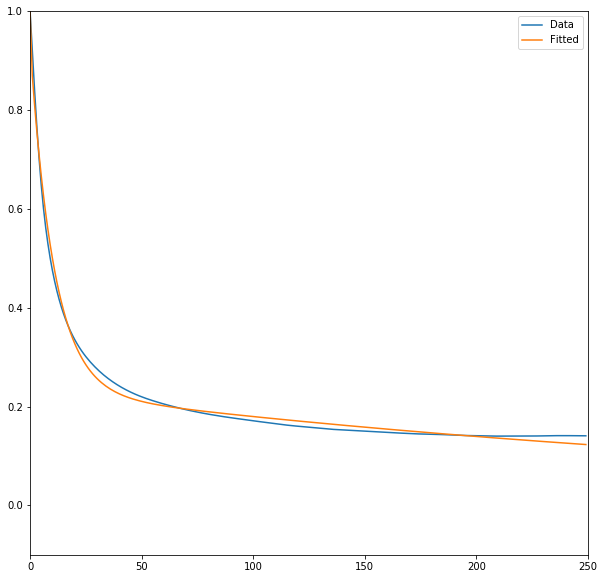

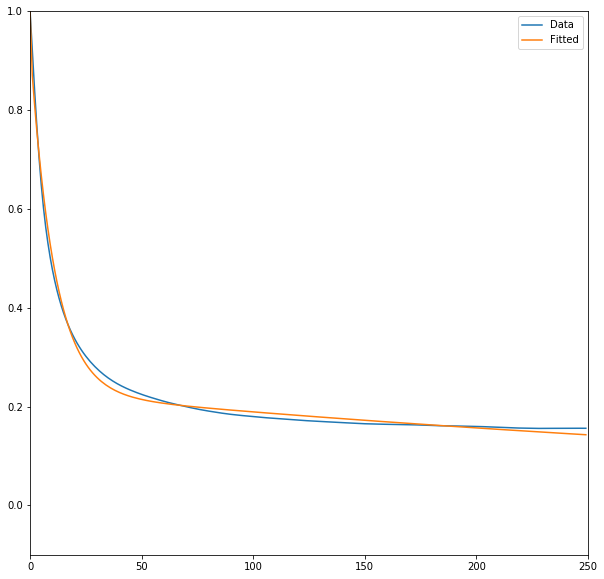

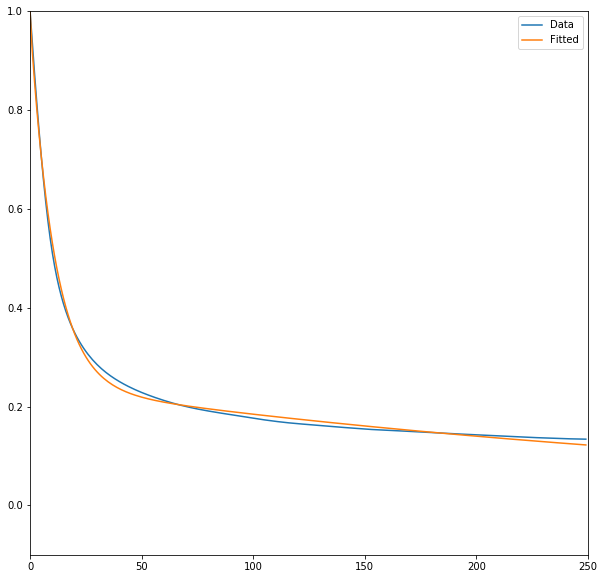

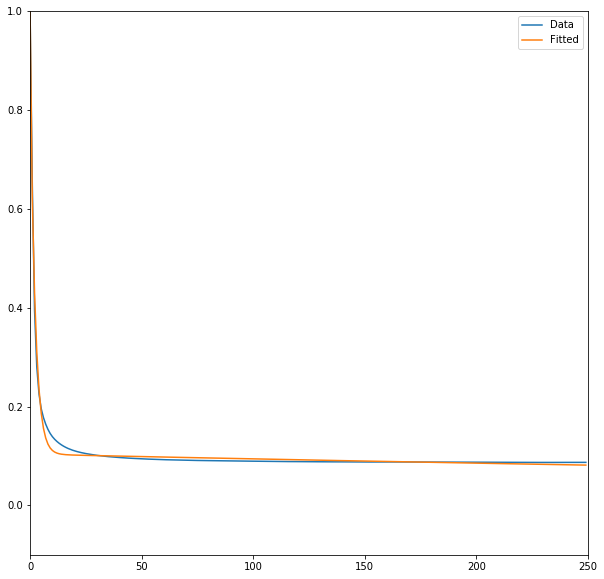

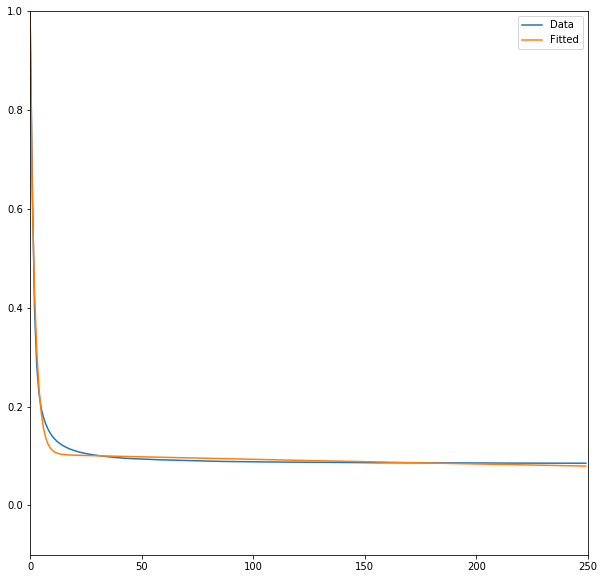

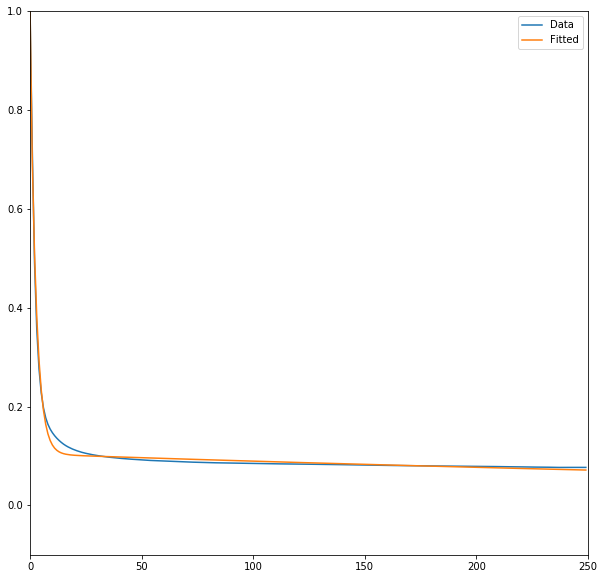

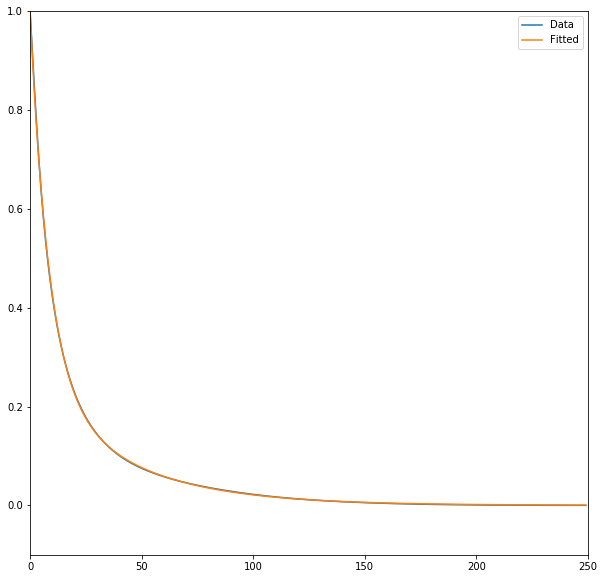

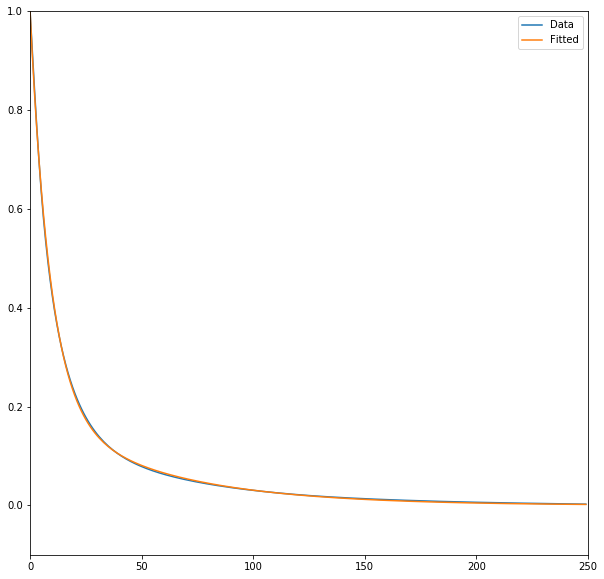

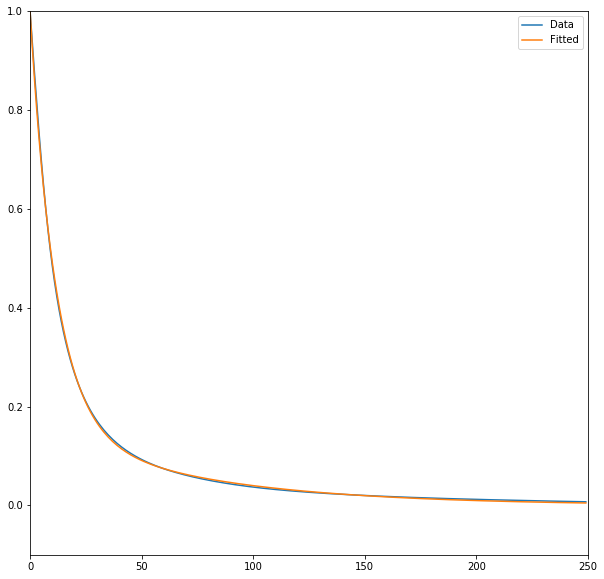

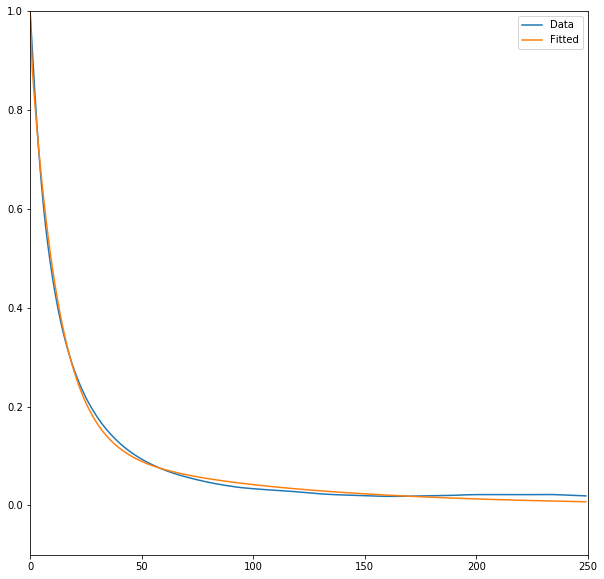

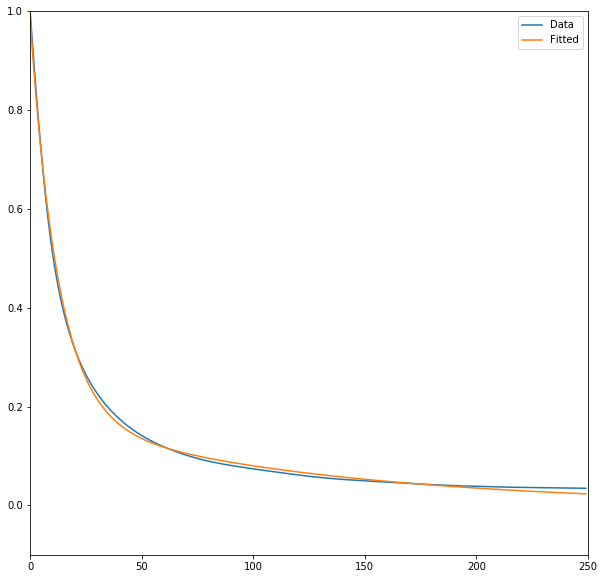

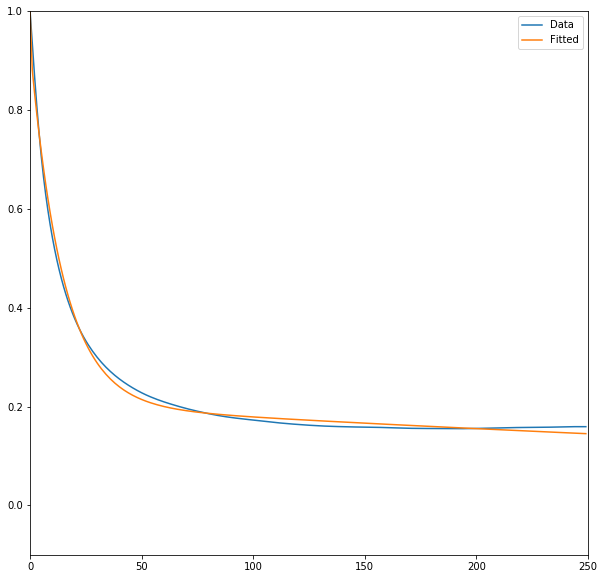

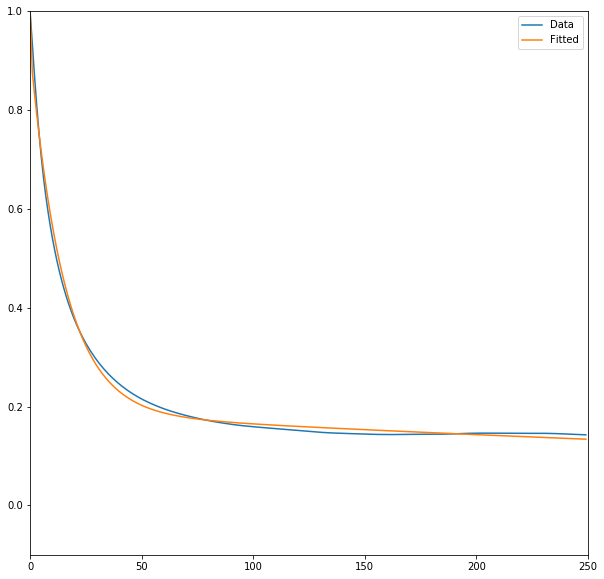

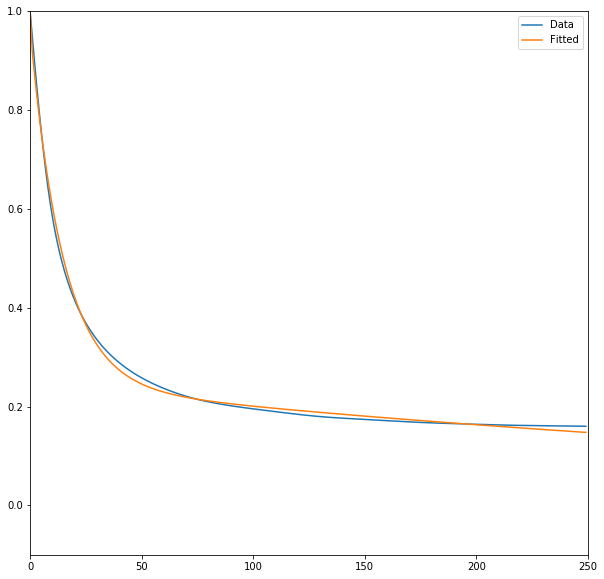

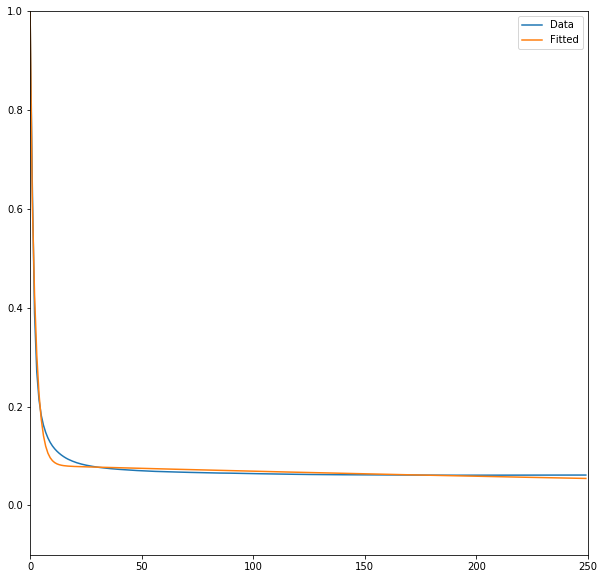

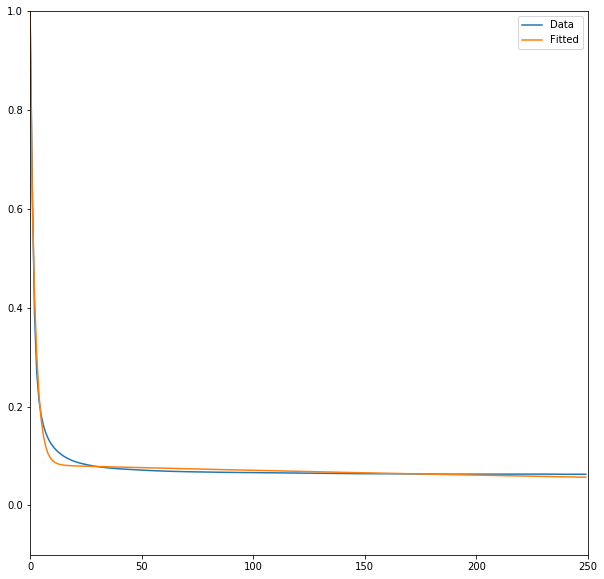

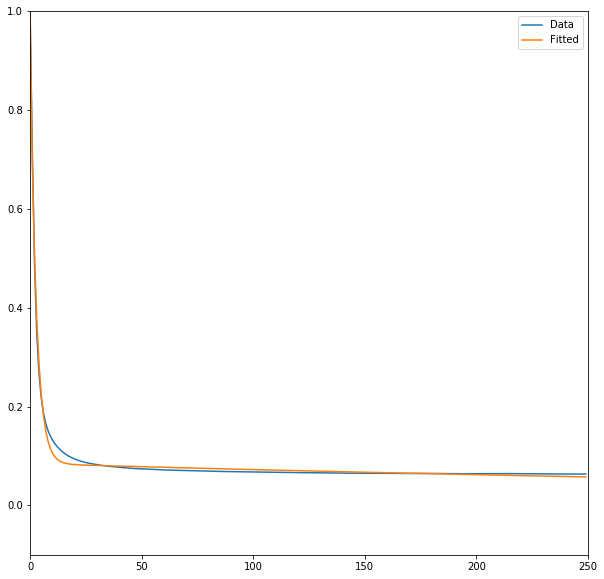

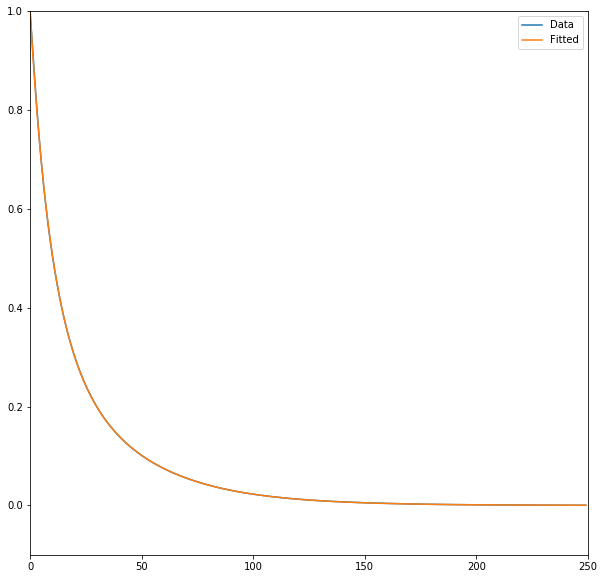

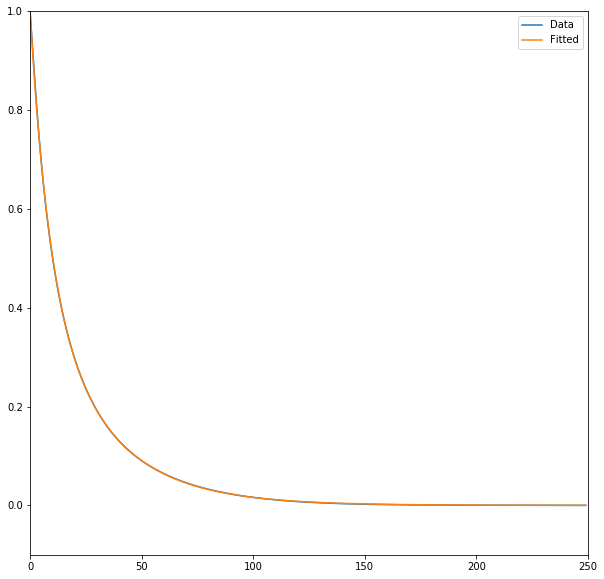

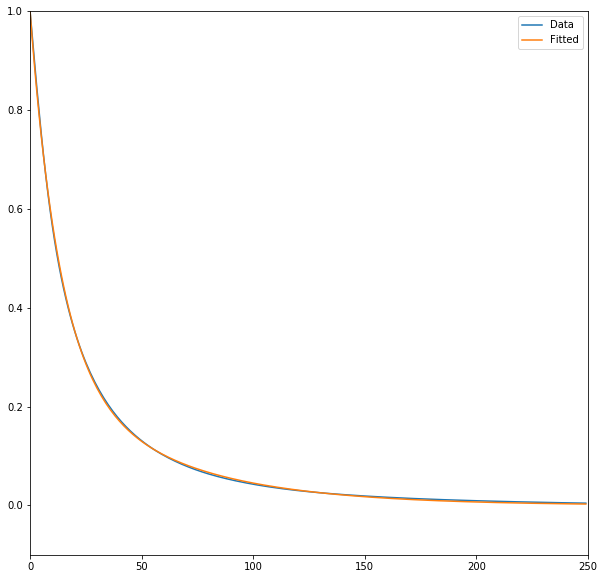

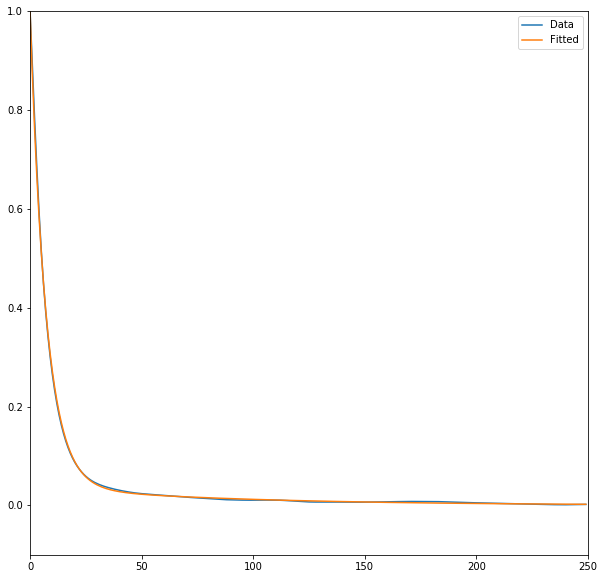

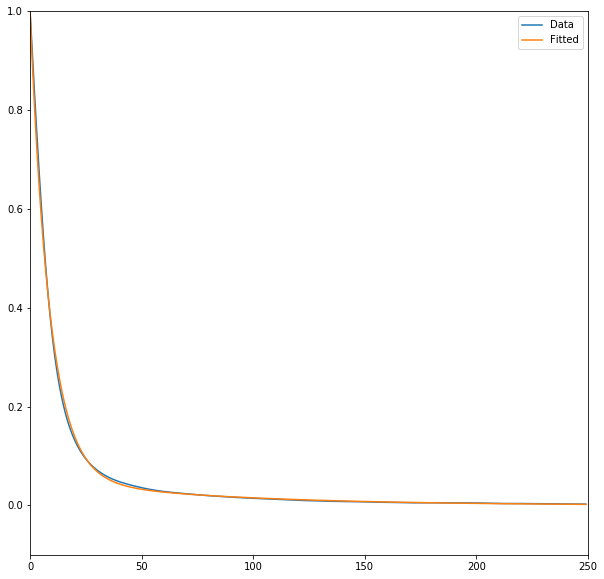

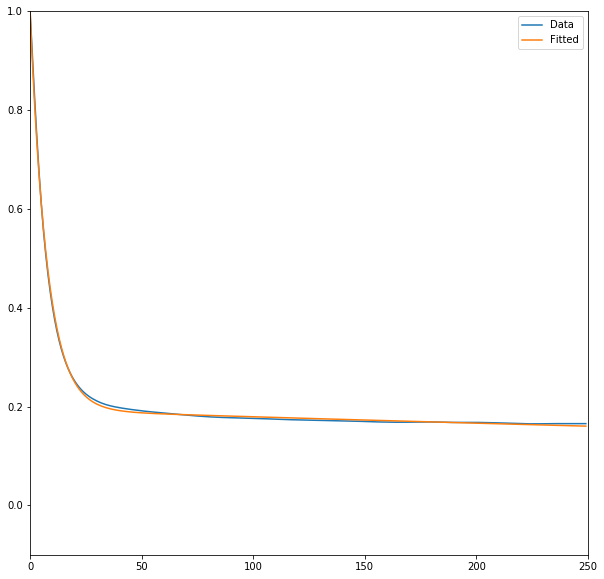

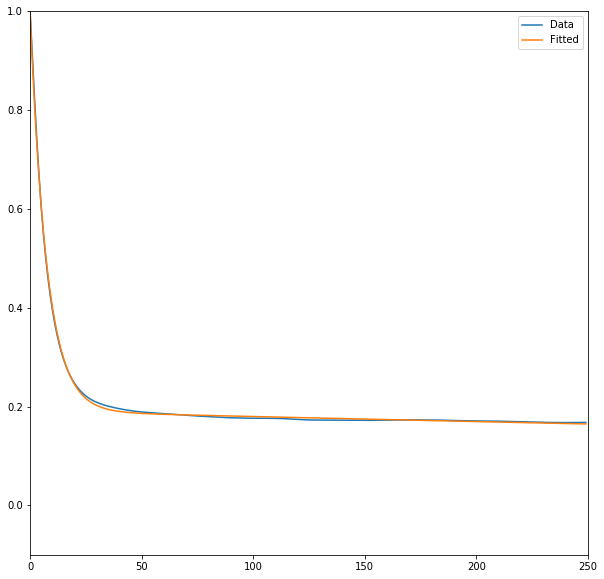

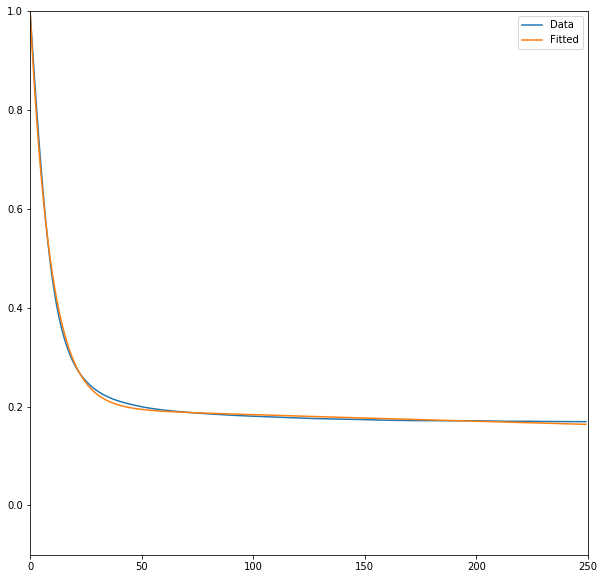

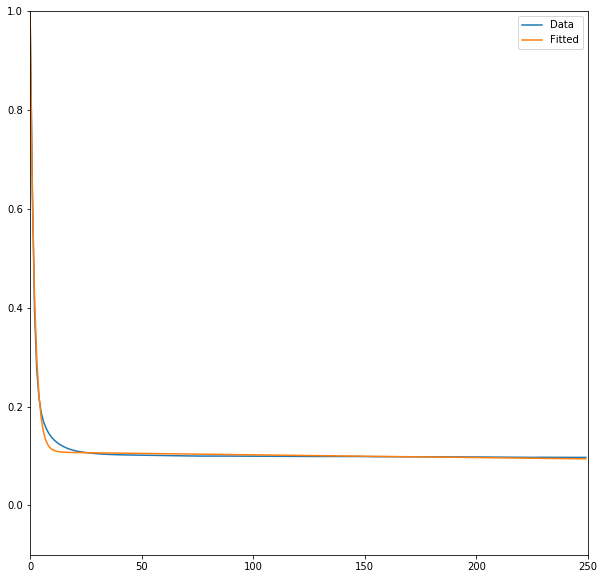

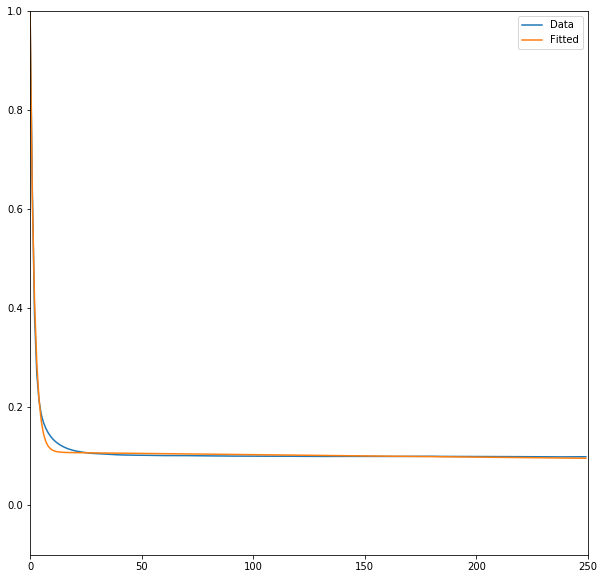

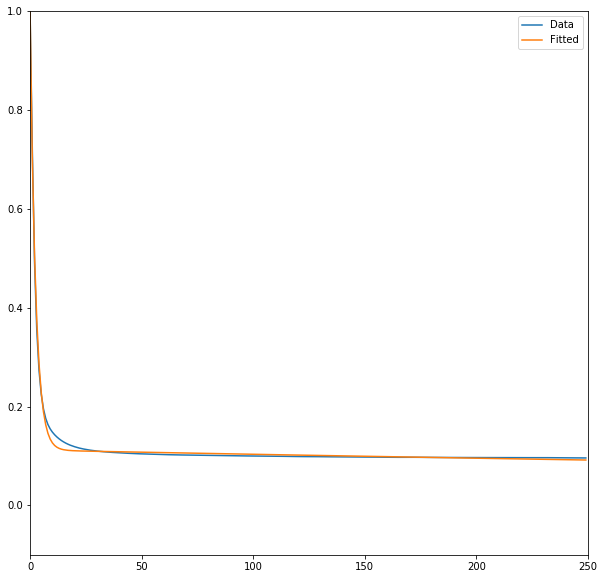

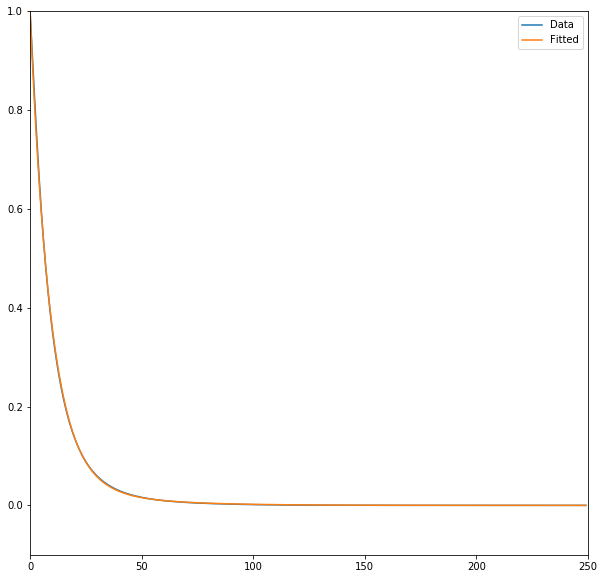

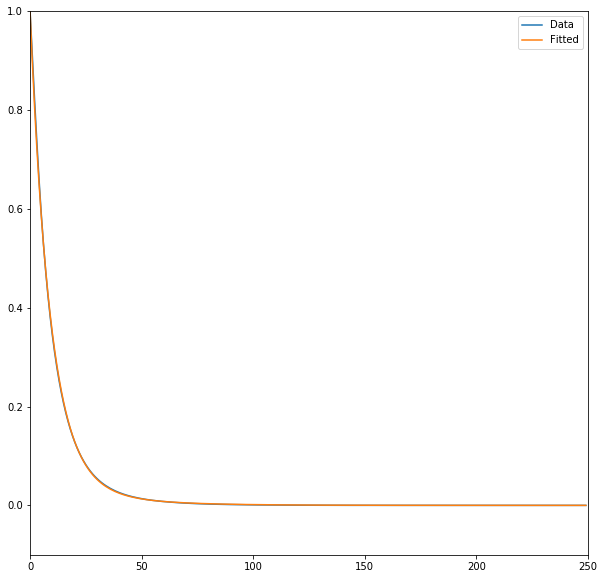

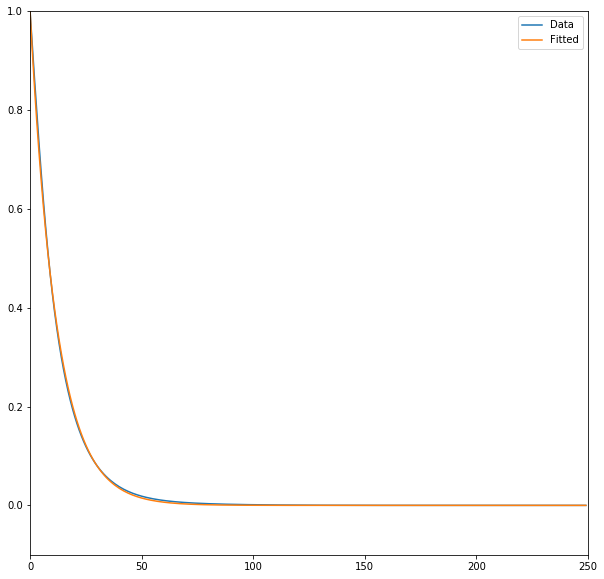

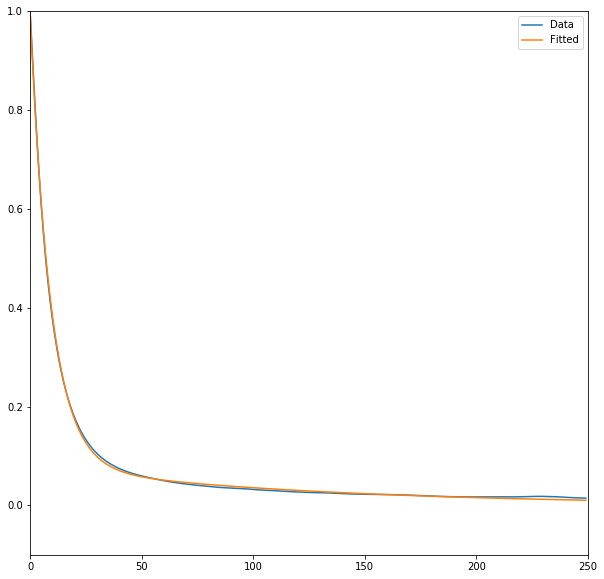

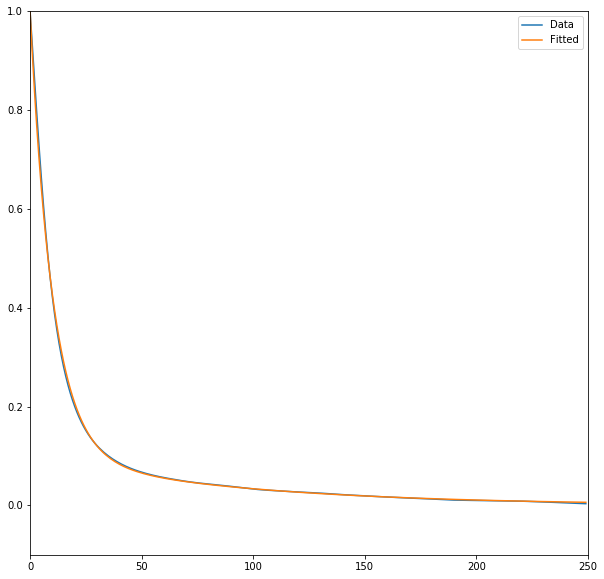

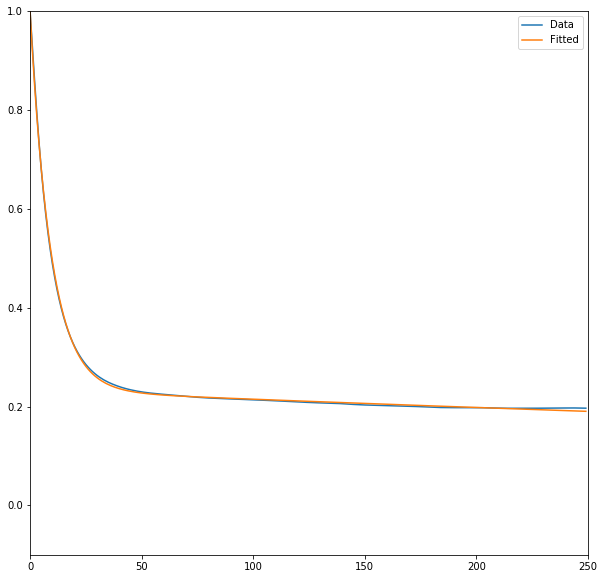

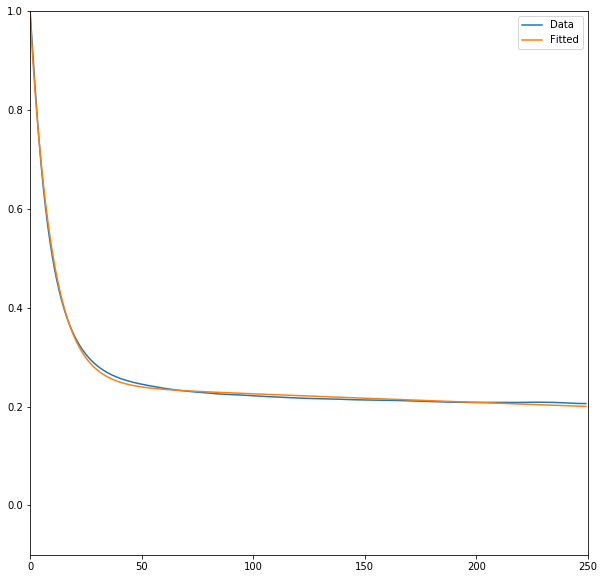

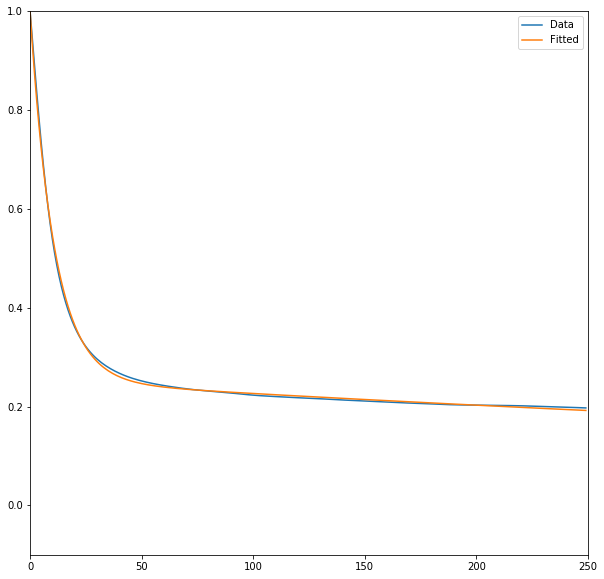

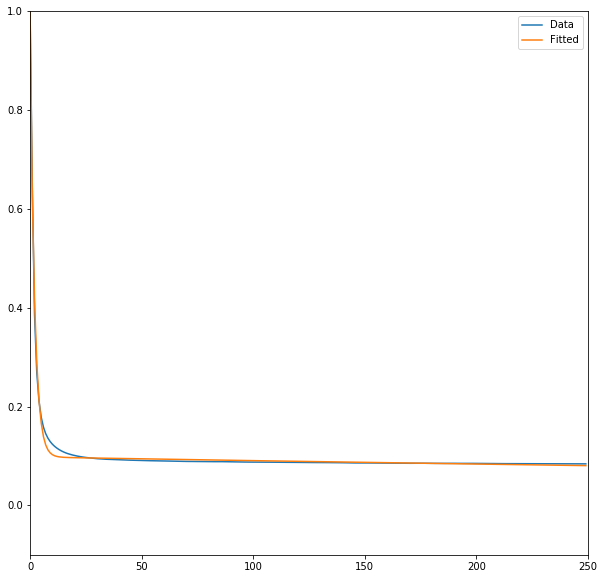

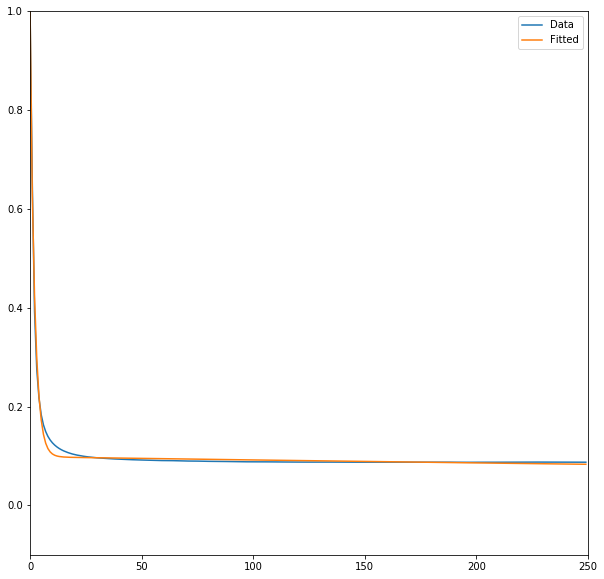

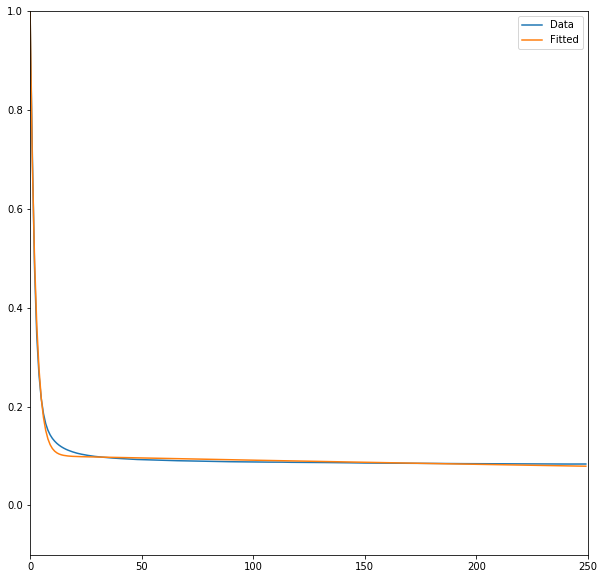

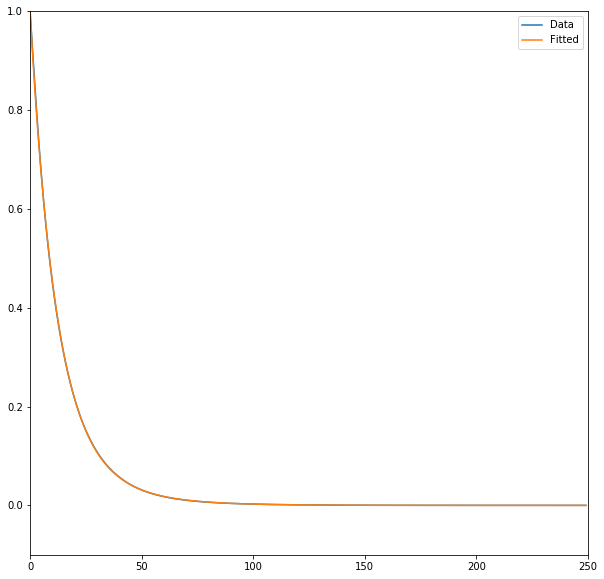

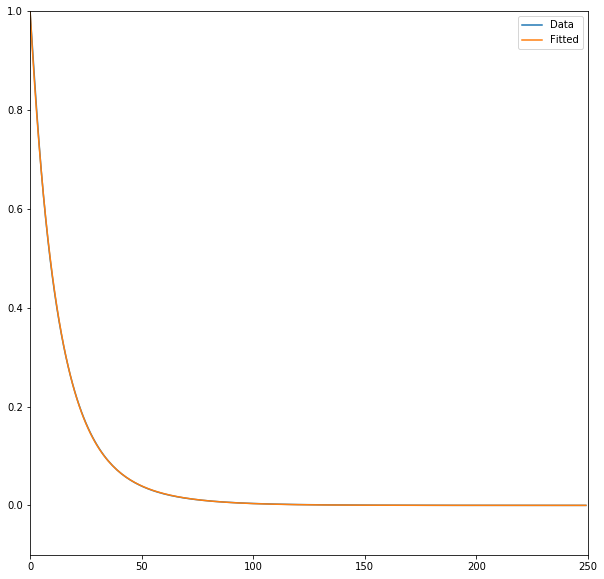

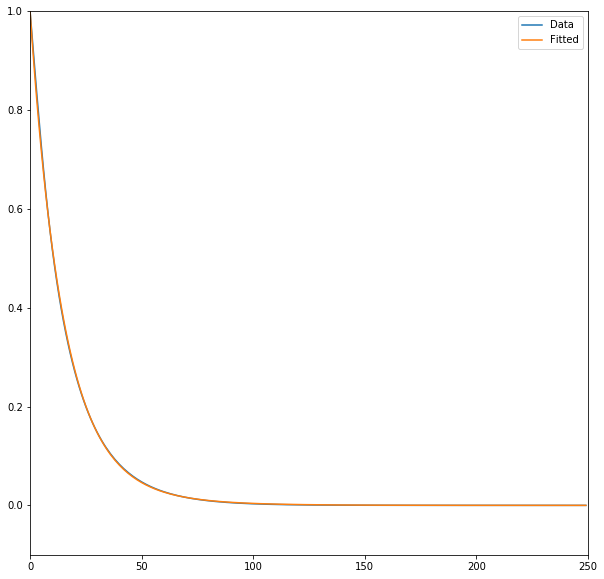

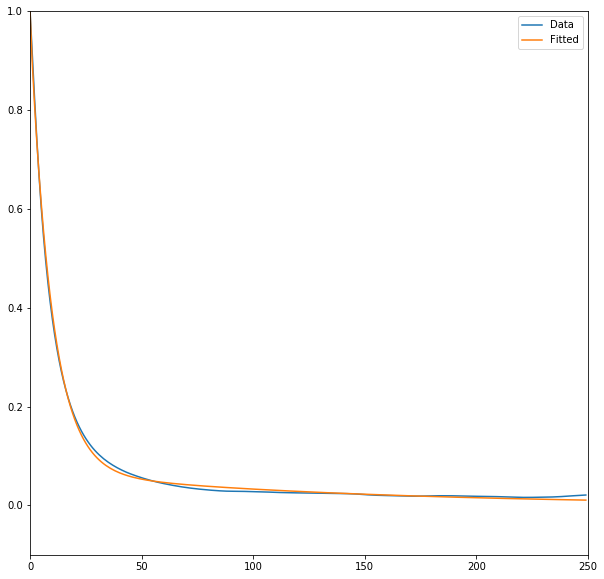

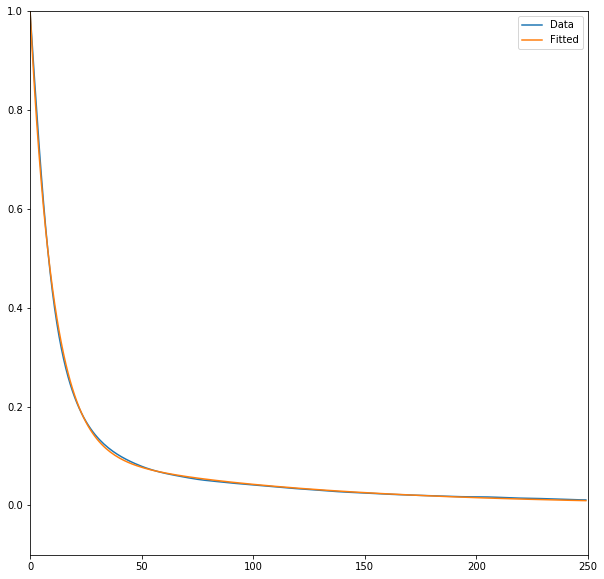

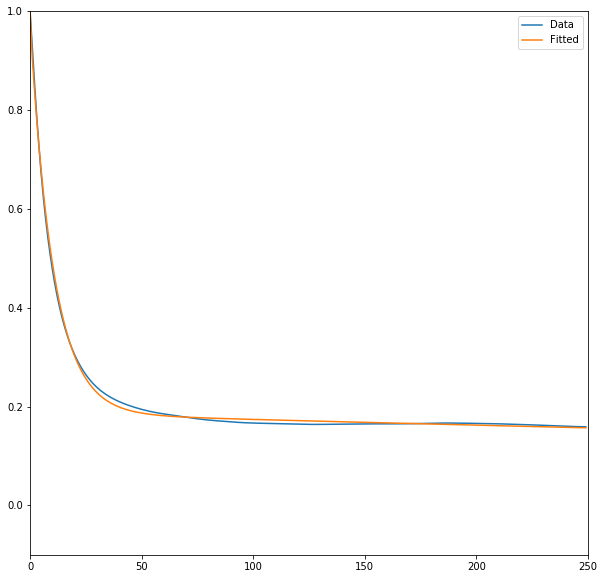

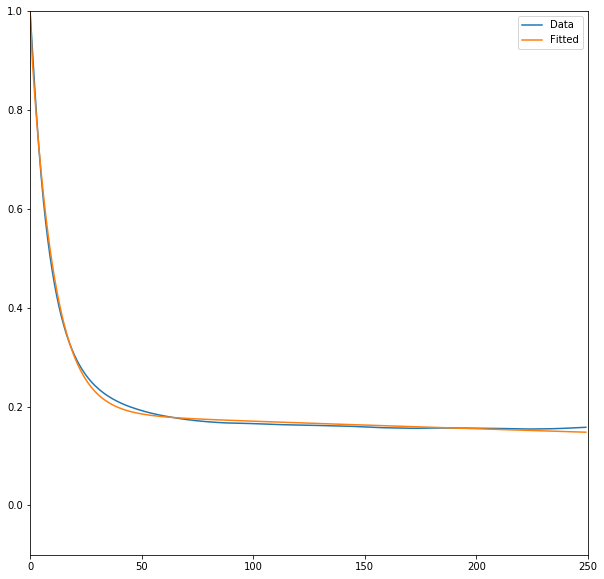

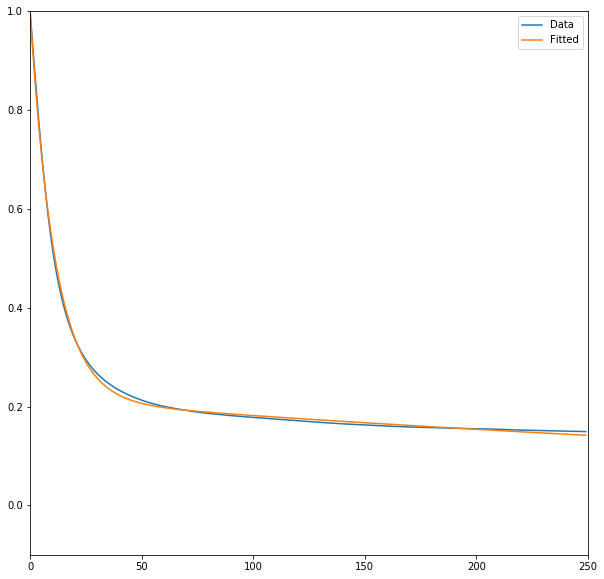

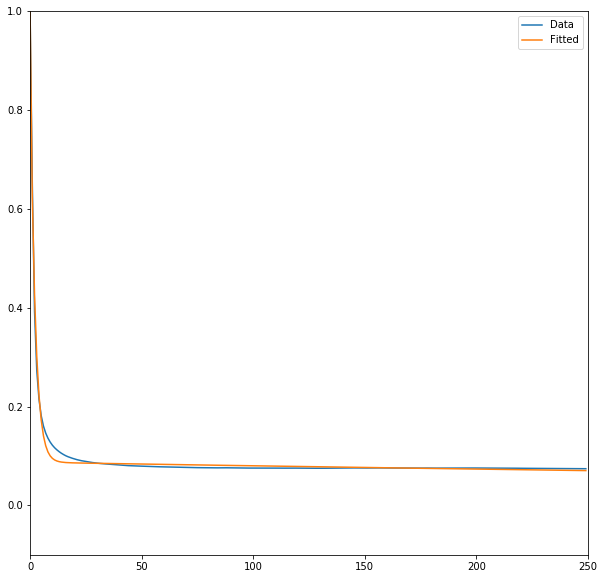

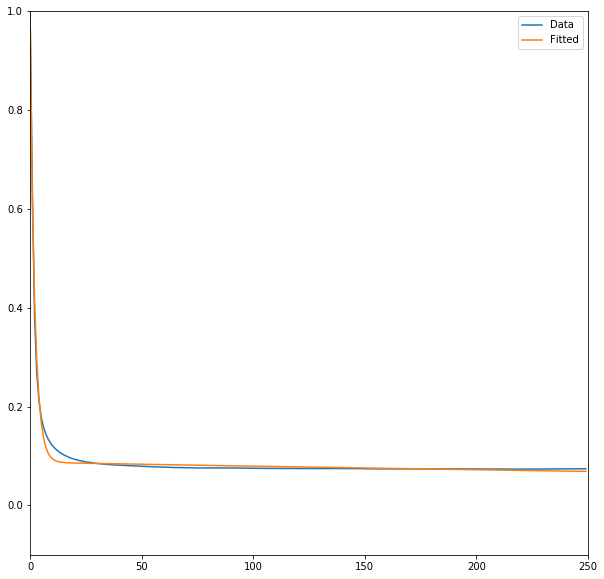

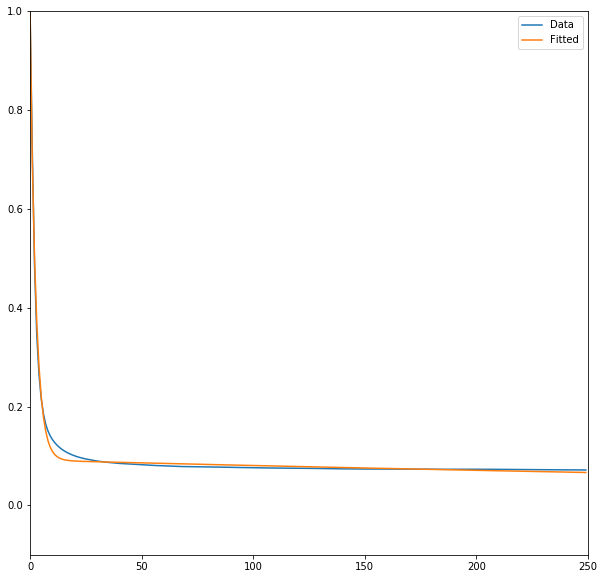

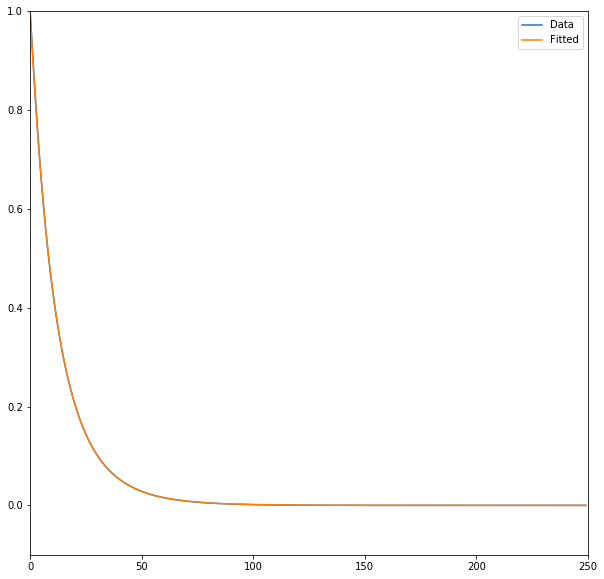

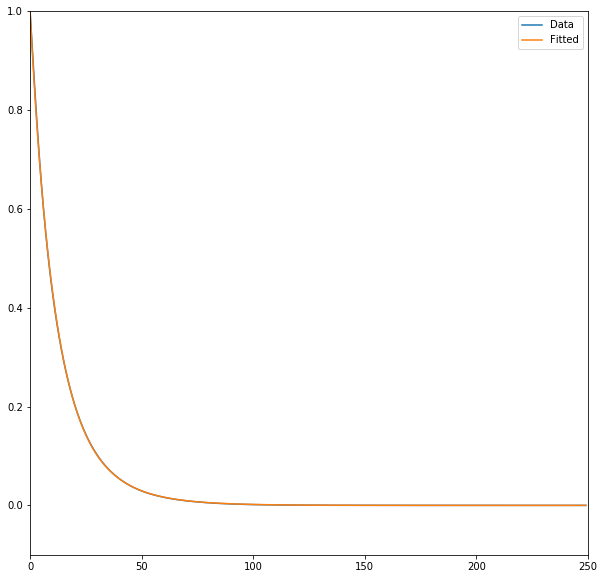

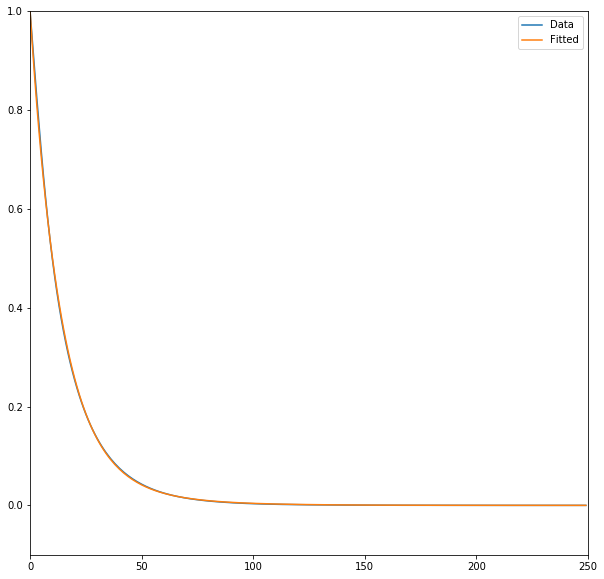

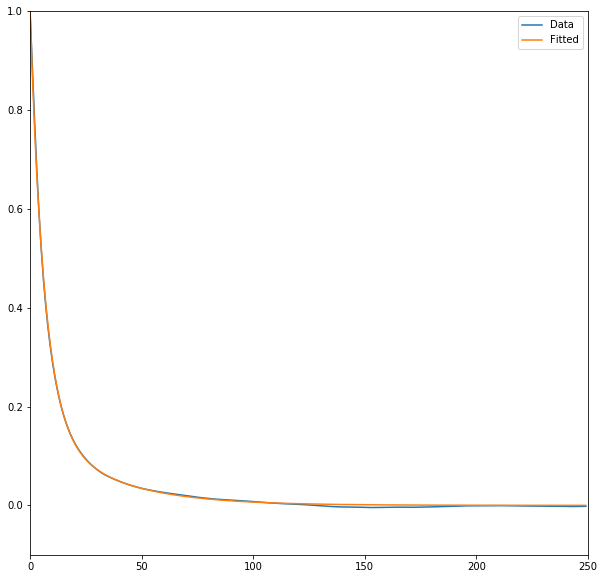

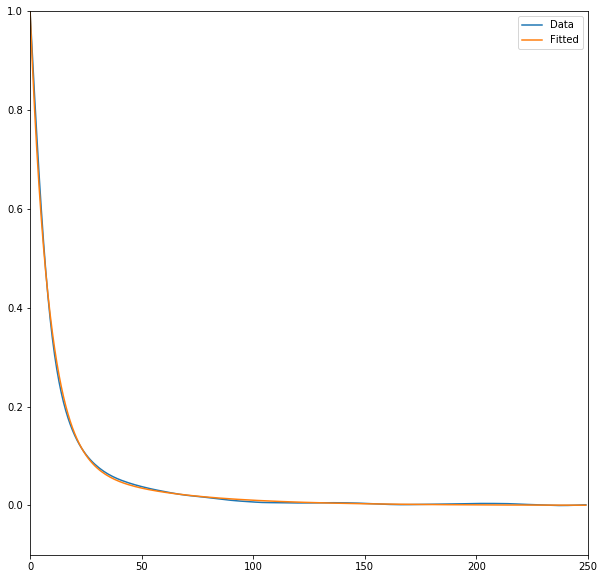

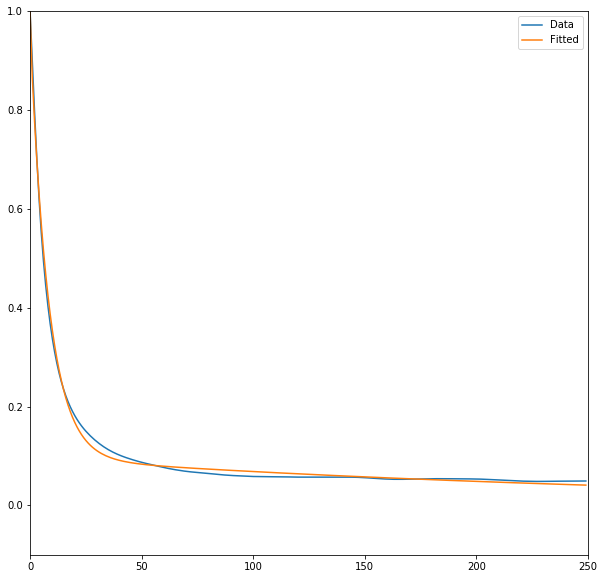

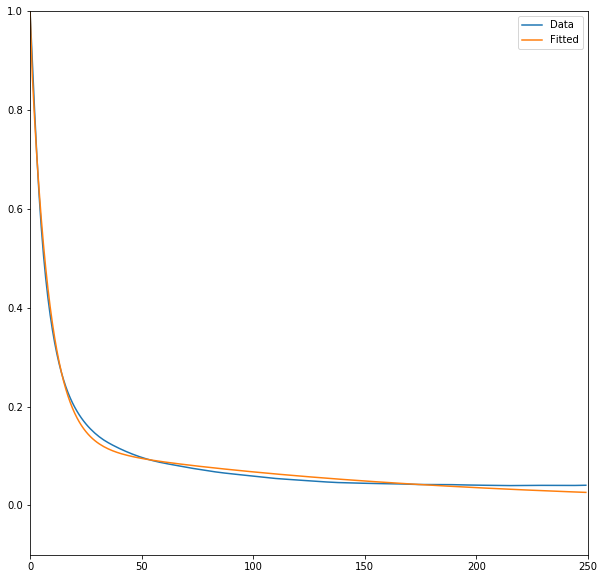

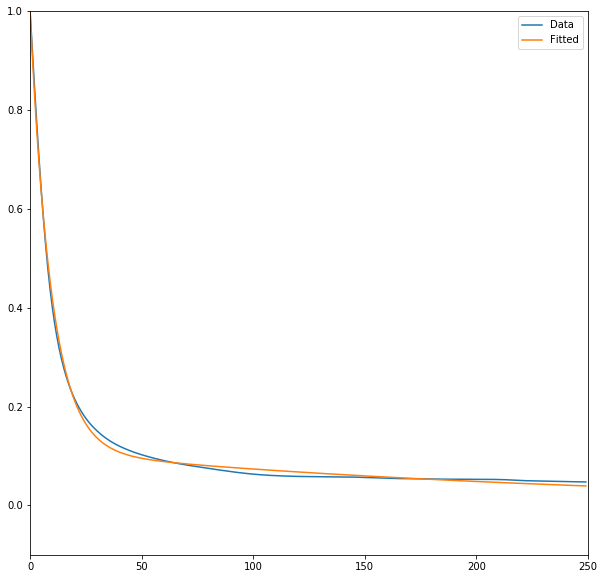

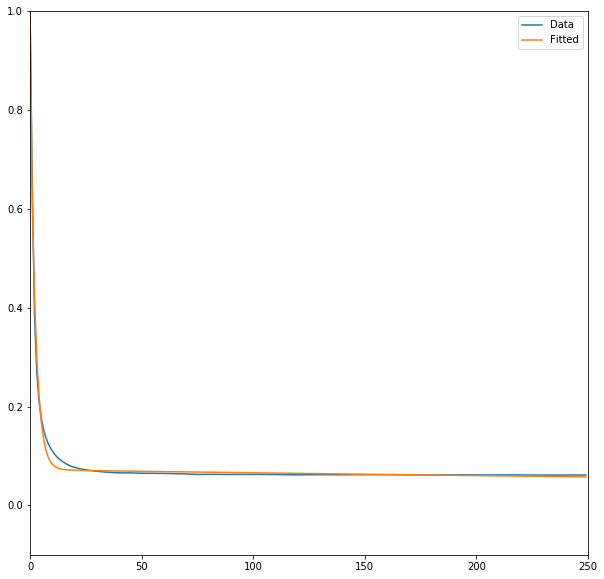

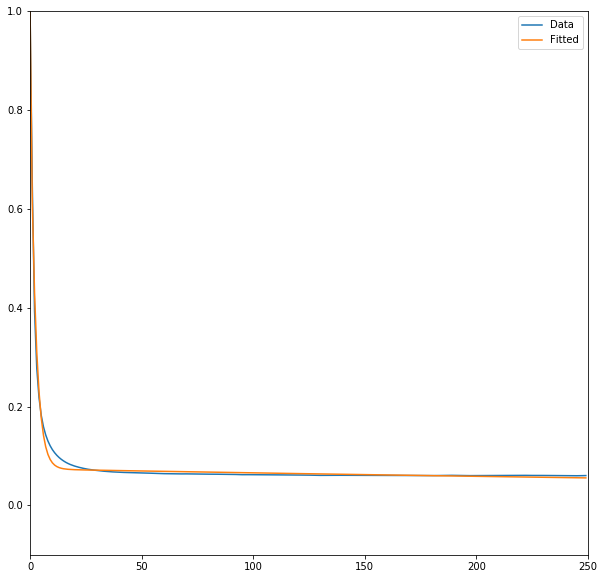

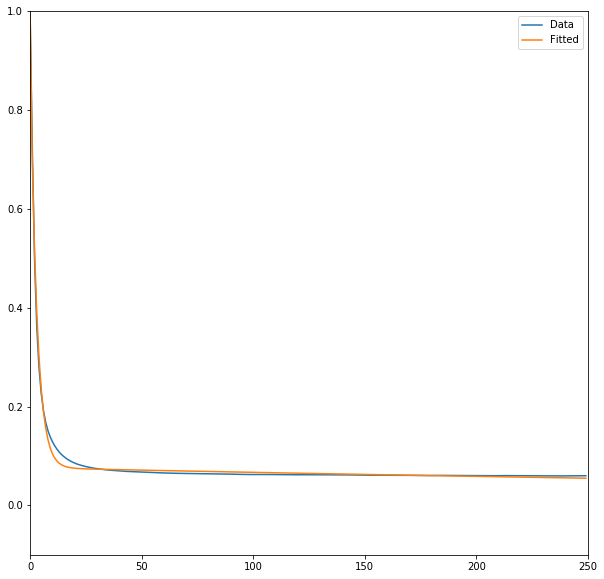

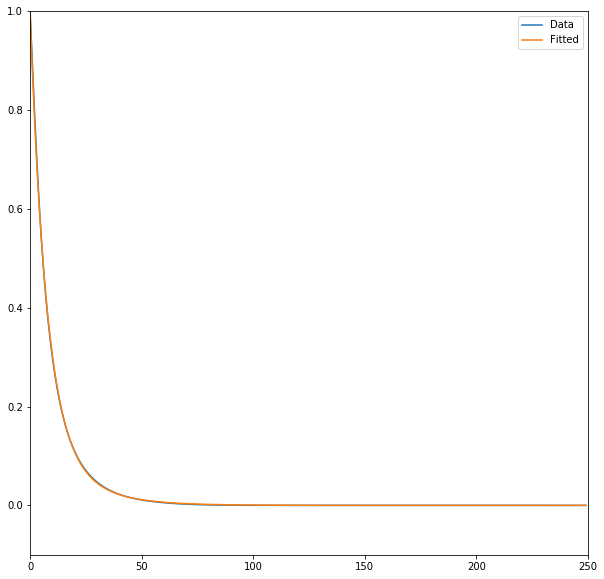

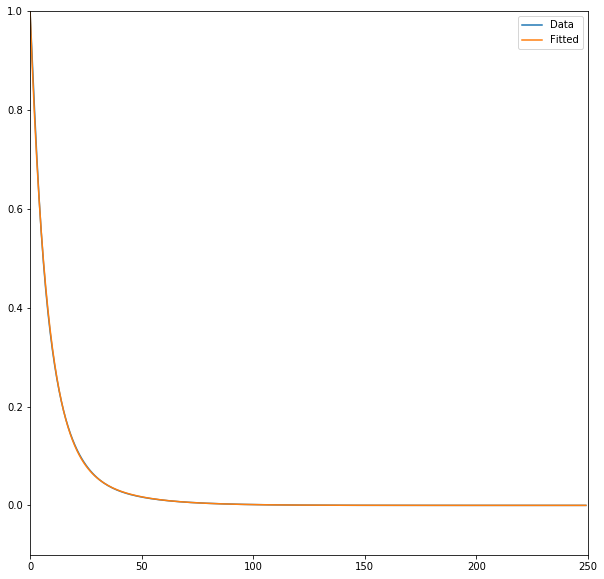

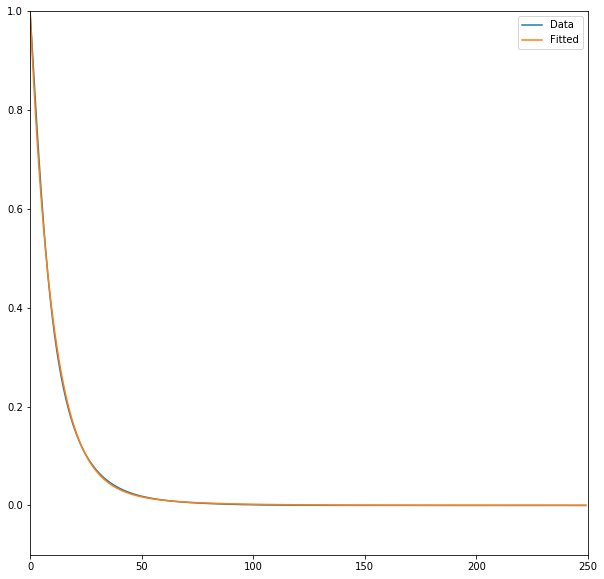

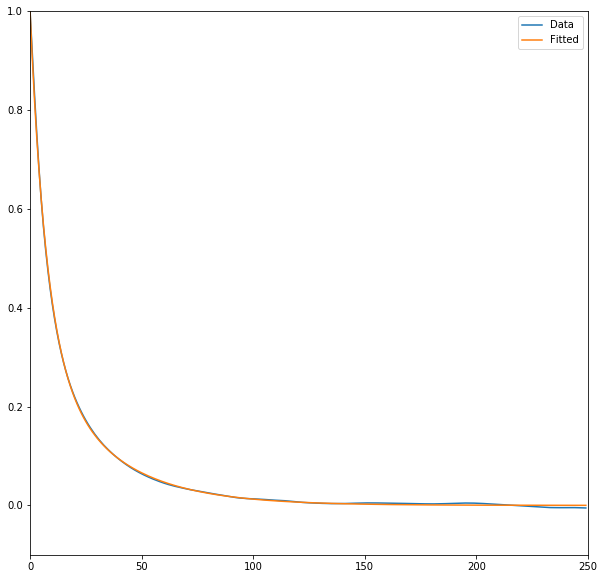

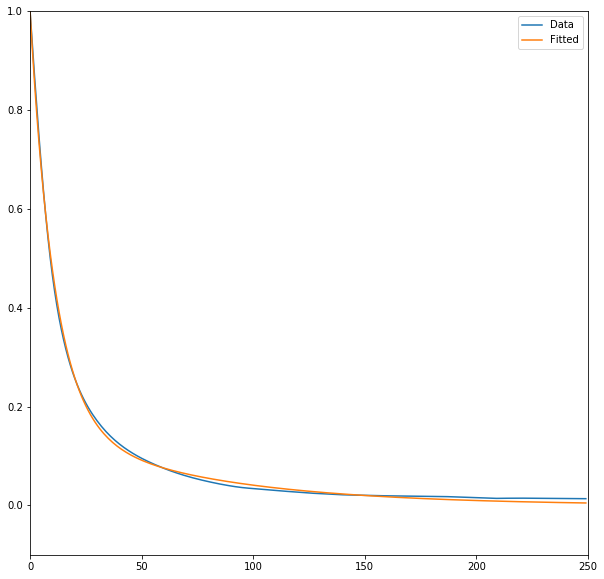

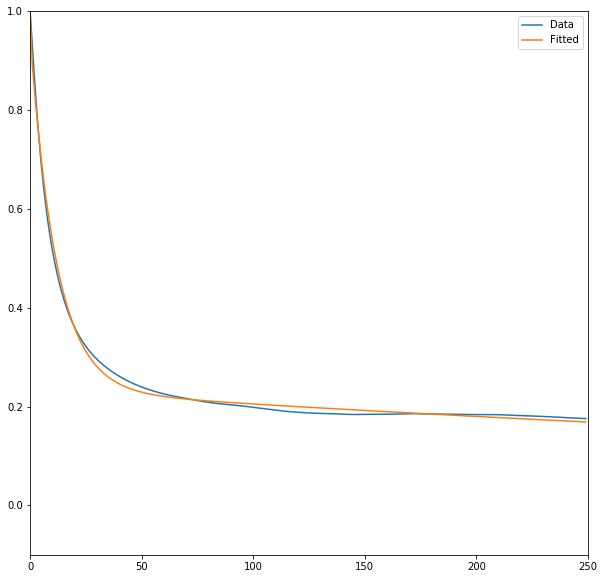

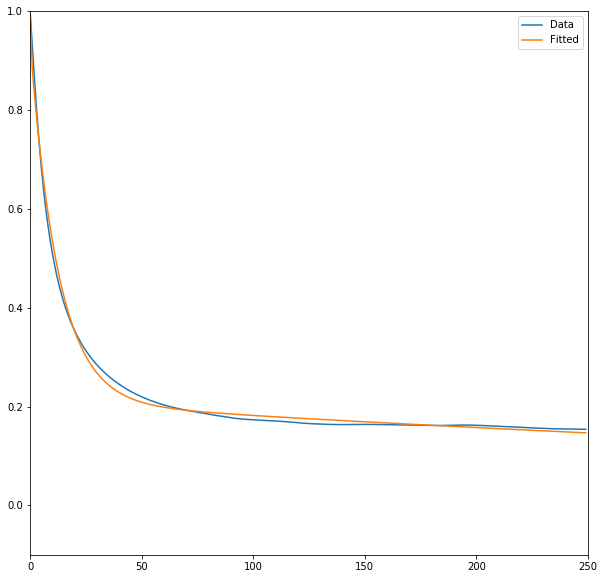

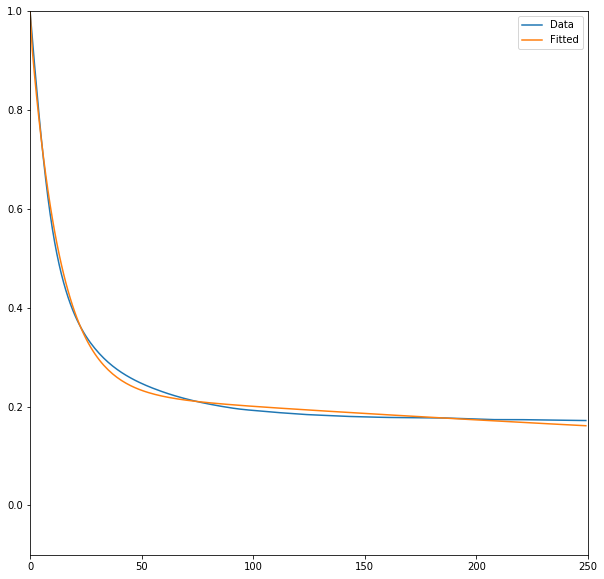

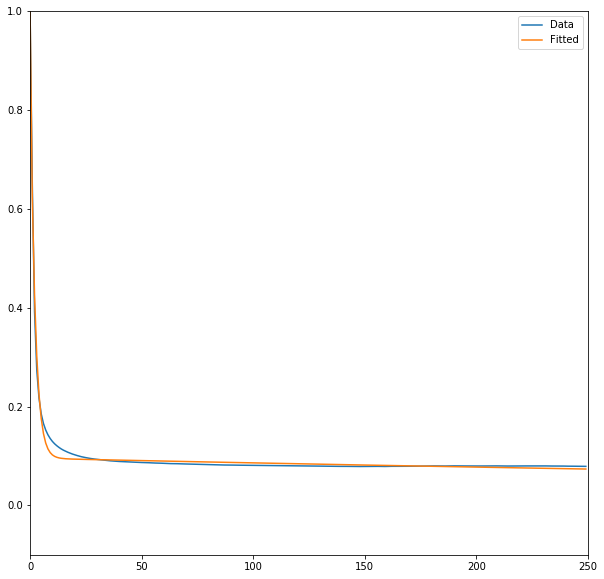

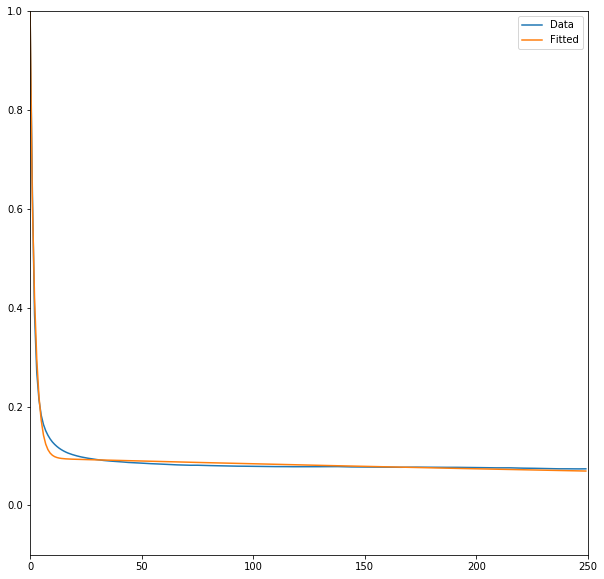

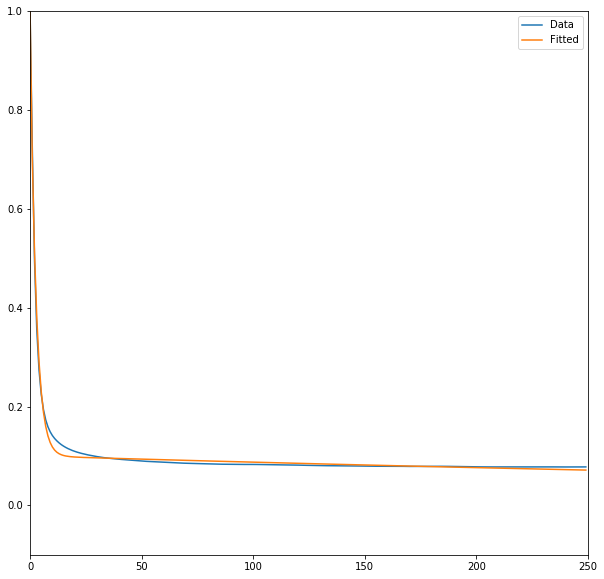

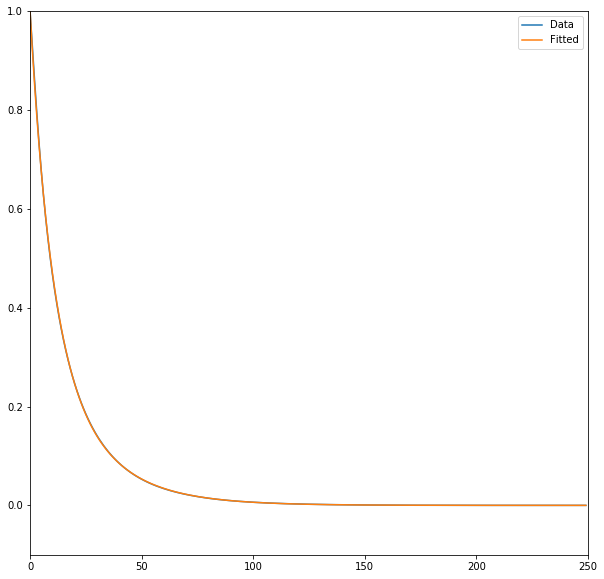

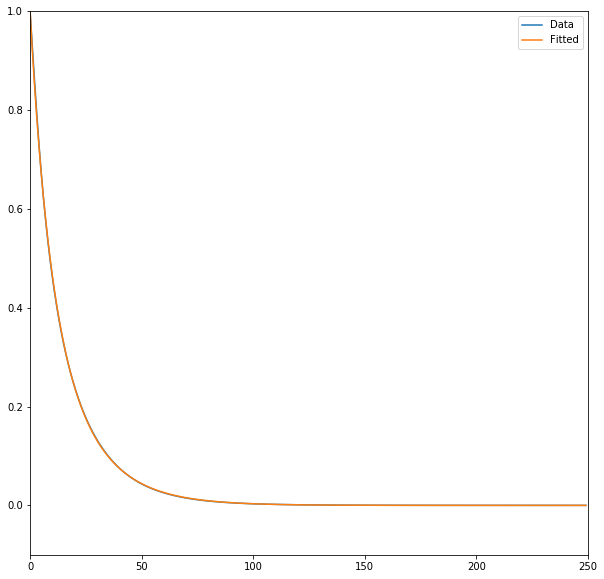

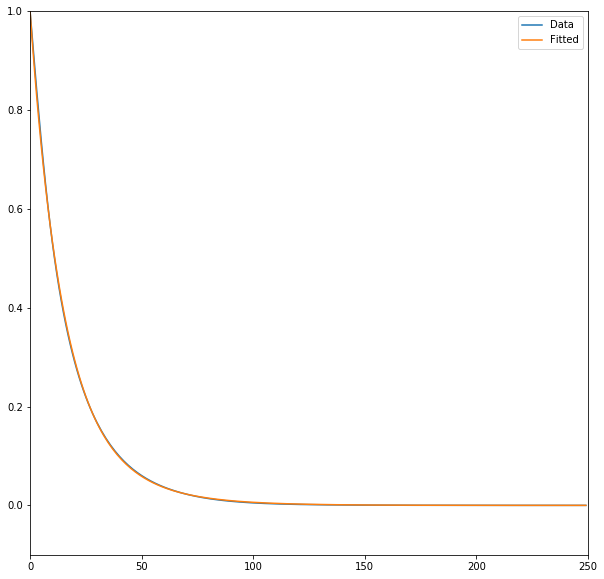

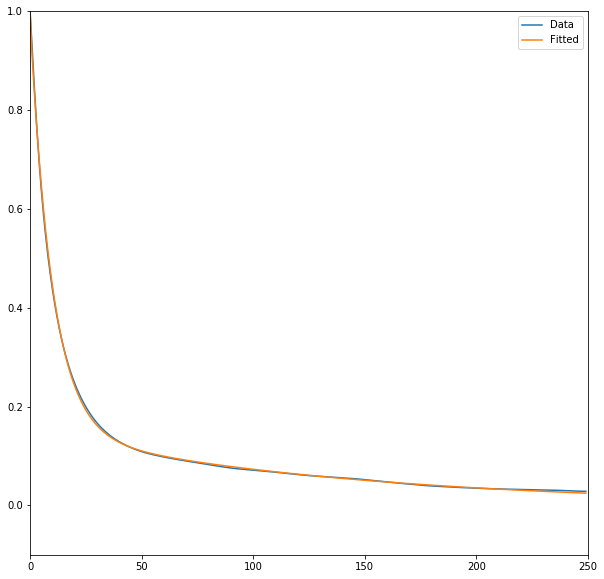

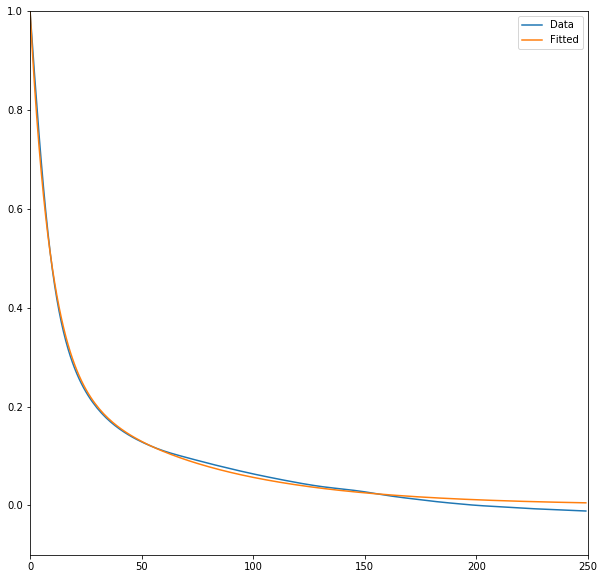

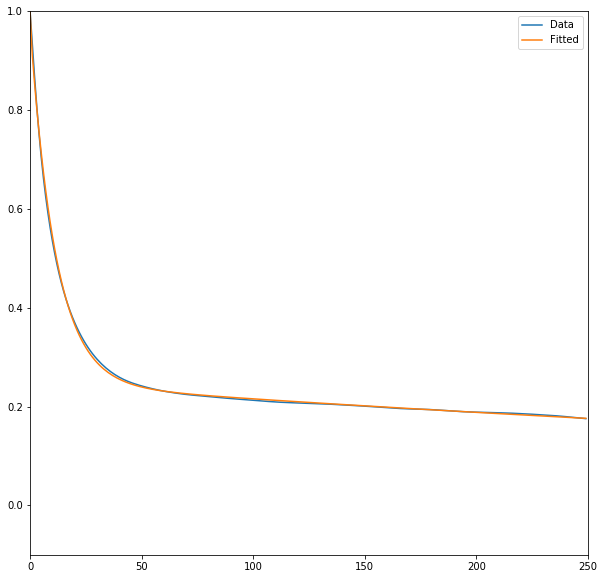

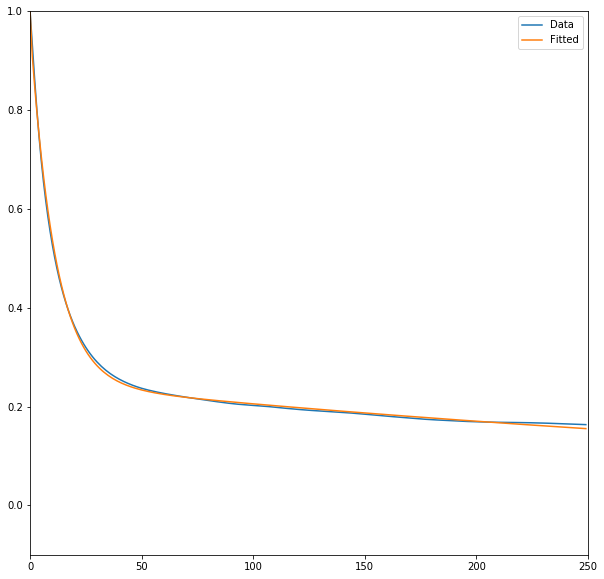

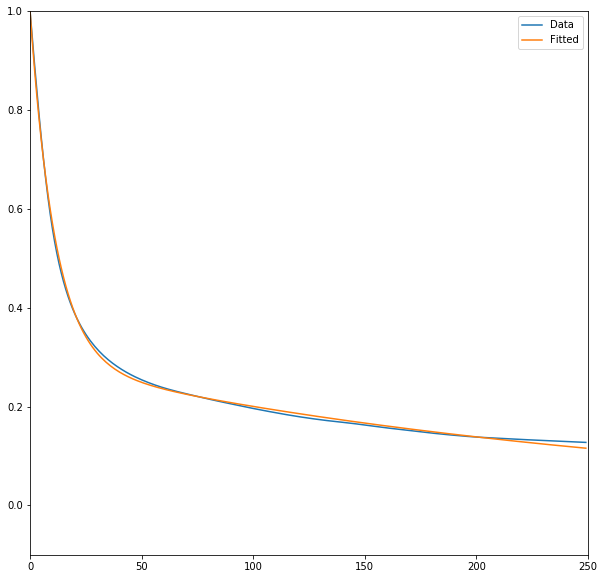

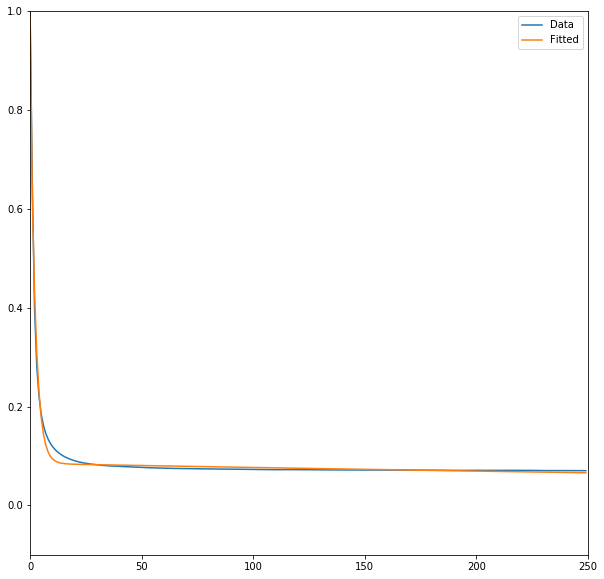

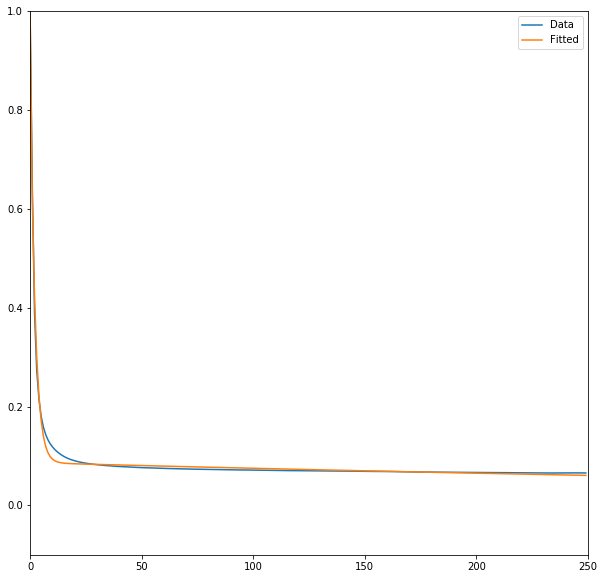

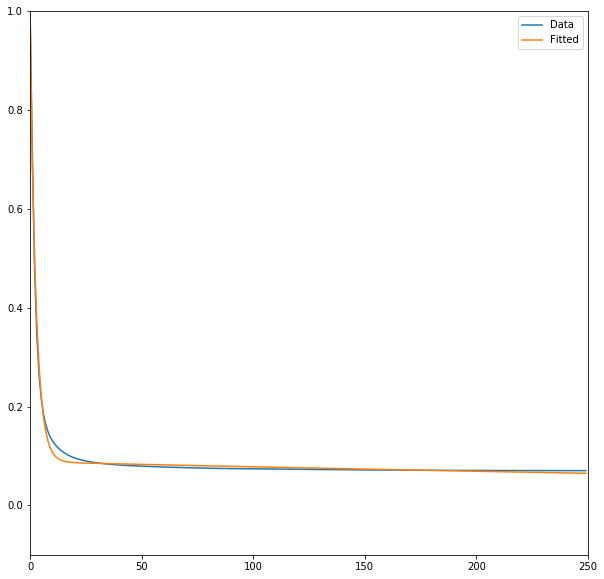

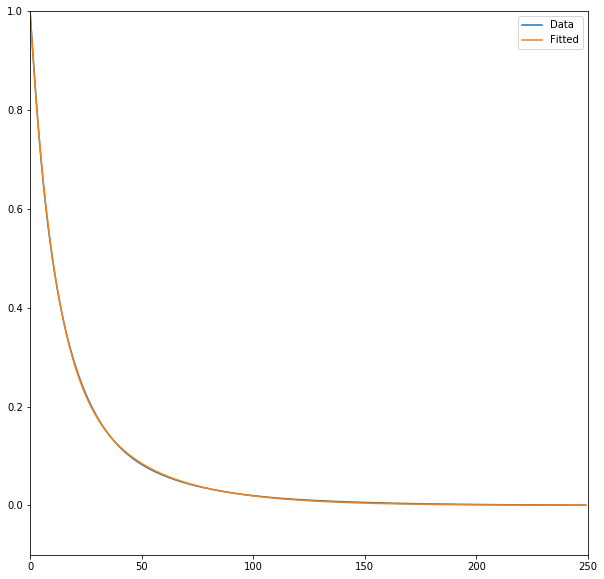

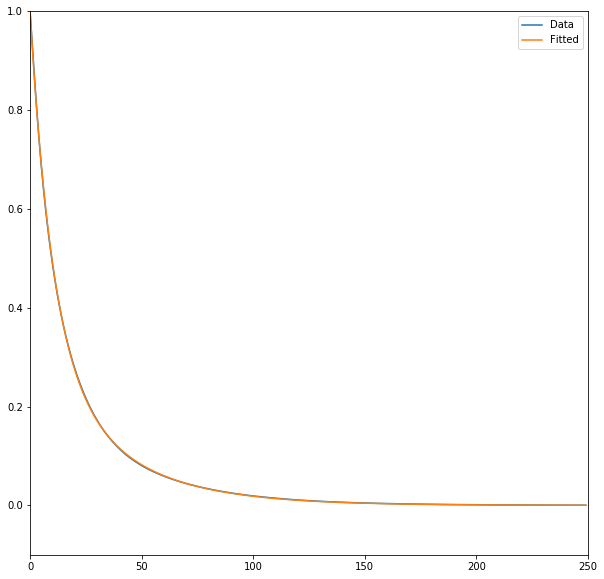

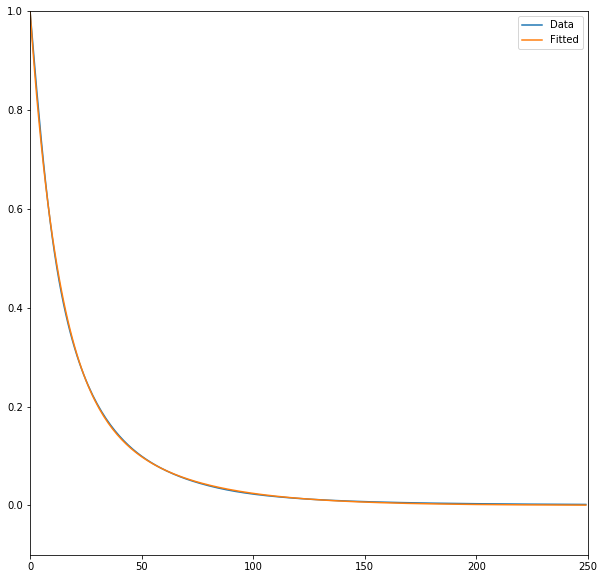

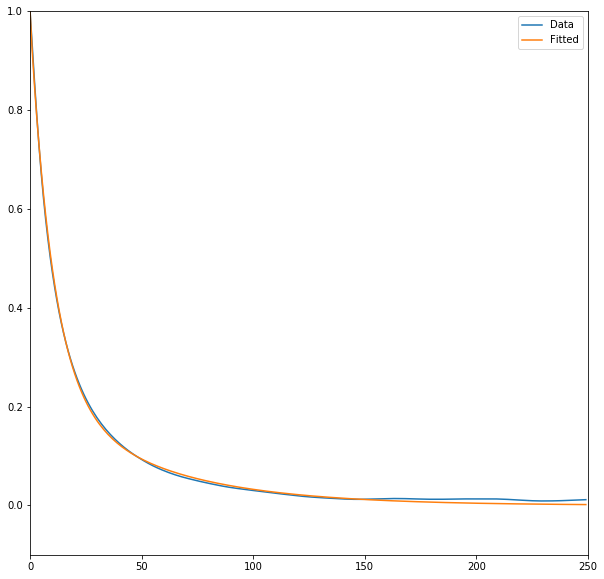

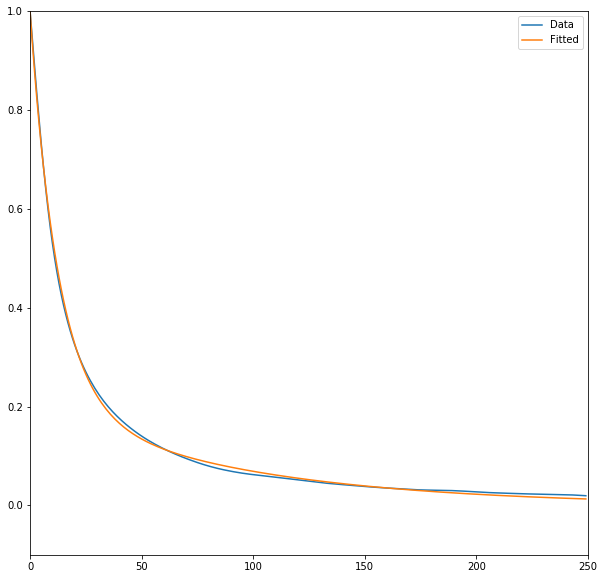

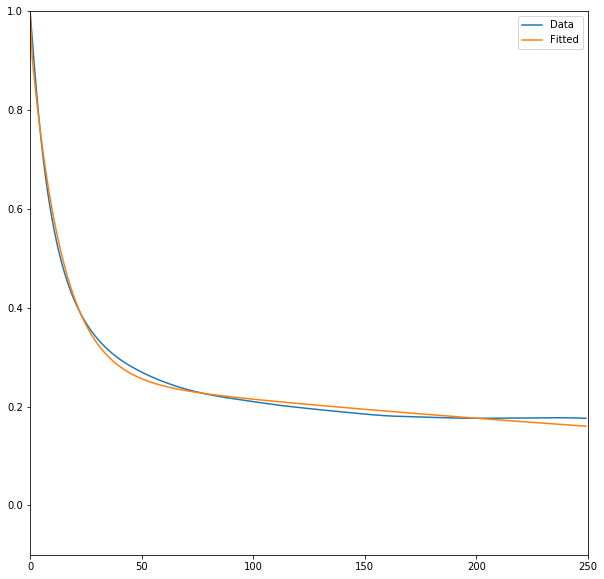

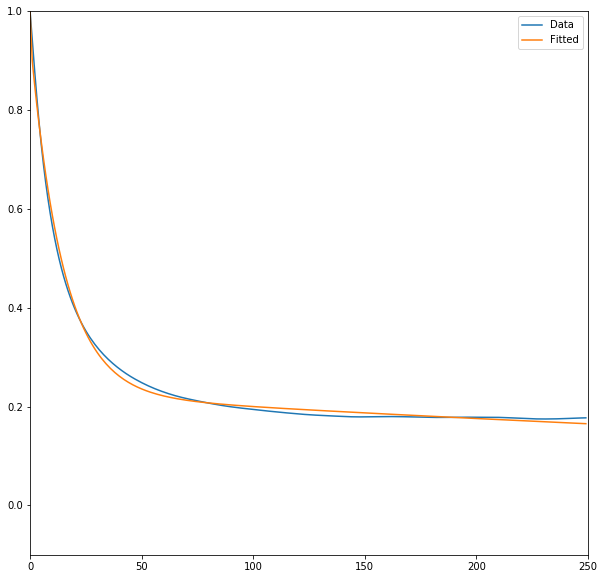

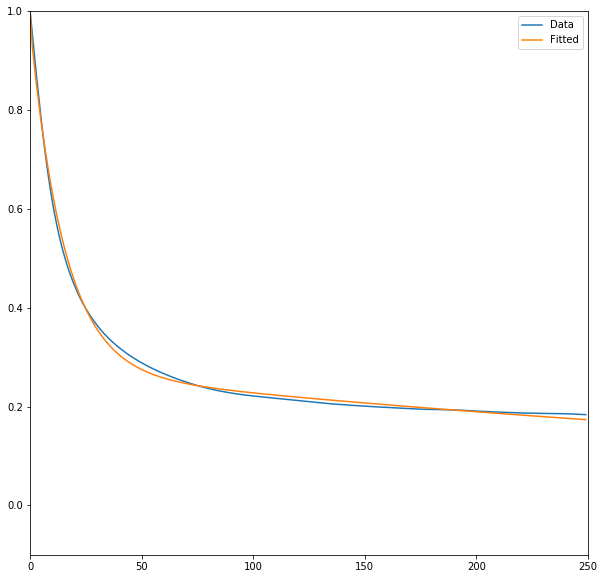

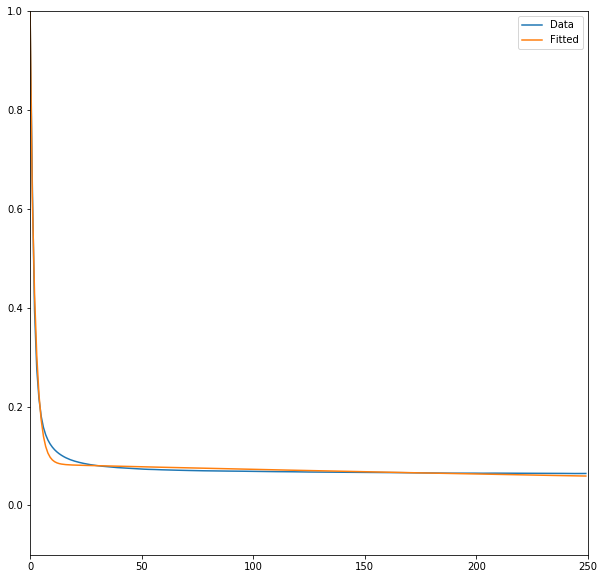

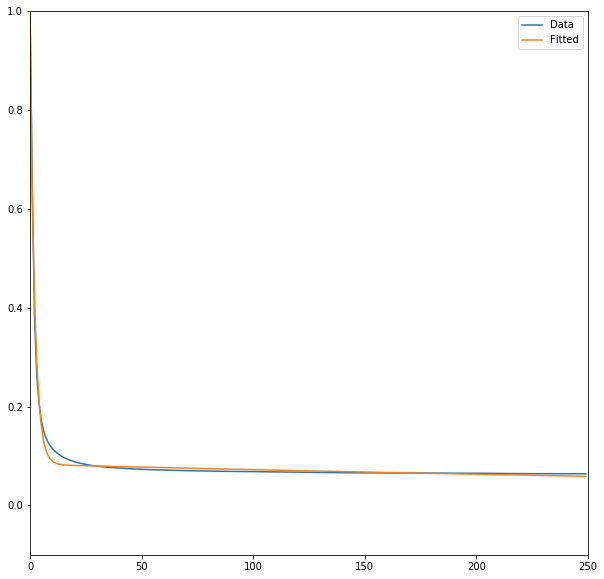

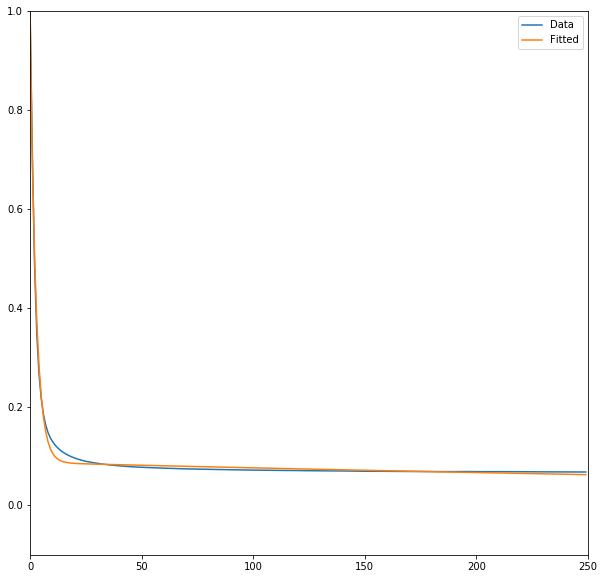

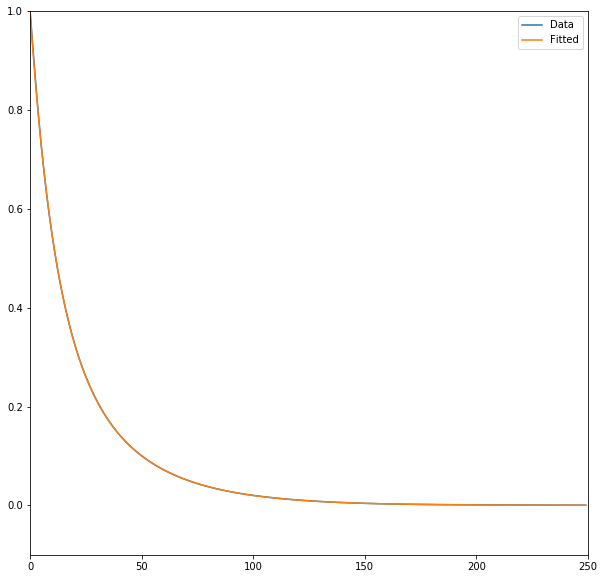

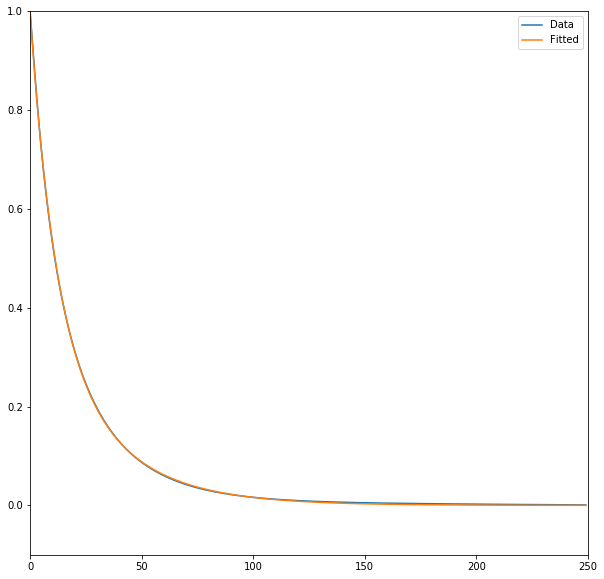

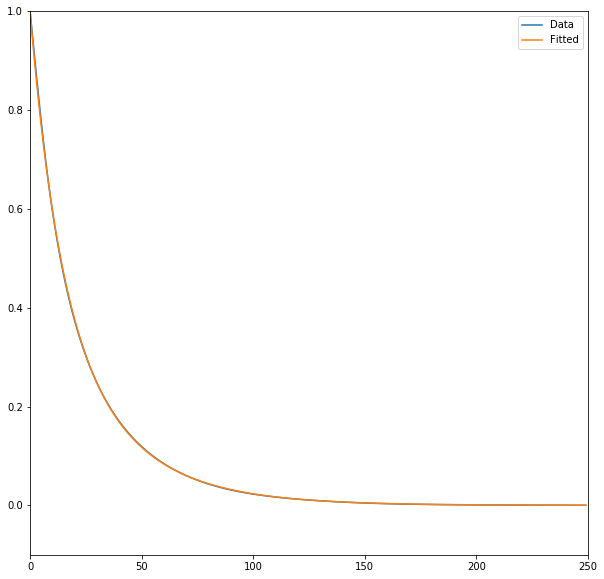

In [120]:
dirs = os.listdir(source_path)

for cdir in ['5', '13']: 
    dirs.remove(cdir)
    dirs.extend([os.path.join(cdir, d) for d in os.listdir(os.path.join(source_path, cdir))])

for dir_name in dirs:
    if dir_name.startswith('.'):
        continue
    data_path = os.path.join(source_path, dir_name) 
    data = read_data(data_path)
    
    dir_path = os.path.join(data_path, 'results')
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print('Current directory: {}'.format(dir_path))
    for tag in tqdm(data):
        exp_data = normalization(data, tag=tag)
        n = exp_data.shape[0]

        scores = dict()
        for i in range(100):
            x = get_x0()

            f = lambda x: func(x, exp_data)
            res = minimize(f, x, options={'ftol': 1e-9, 'disp': False},
                           method='SLSQP',
                           constraints=cons,
                           bounds=bounds)
            a1, a2, a3, a, b, c = res.x

            result = {
                'x0': list(x),
                'x': list(res.x),
                'SSE': f(res.x),
                'a1': a1,
                'a2': a2,
                'a3': a3,
                'a': a,
                'b': b,
                'c': c,
                'exp_data': list(exp_data),
                'fitted': list(f_param(res.x, exp_data.shape[0])),
            }
            scores[result['SSE']] = result

        best = min(scores) 
        result = scores[best]

        r = np.arange(0, n)
        y = result['fitted']
        d = result['exp_data']

        plt.figure(figsize=(10, 10))
        plt.plot(r, d, label='Data')
        # plt.plot(r, z, label='Data S2')
        plt.plot(r, y, label='Fitted')
        plt.legend(loc='best')
        plt.ylim([-0.1, 1])
        plt.xlim([0, 250])
        plt.savefig(os.path.join(dir_path, '{}.png'.format(tag)))
        with open(os.path.join(dir_path, '{}.json'.format(tag)), 'w') as f:
            f.write(json.dumps(result, indent=2))